# Anomaly Detection in Bipartite Graphs - Model Comparison

This notebook compares different models for anomaly detection in bipartite graphs.

In [1]:
# Load the extension
%load_ext autoreload
# Configure it to reload all modules before each cell execution
%autoreload 2

In [2]:
import sys
import os
sys.path.append('..')

# --- MPS Fallback ---
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
print(f"PYTORCH_ENABLE_MPS_FALLBACK set to: {os.environ.get('PYTORCH_ENABLE_MPS_FALLBACK')}")

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch_geometric.transforms as T
import torch_geometric
from sklearn.metrics import precision_recall_curve

# Import custom modules
from src.data.dataloader import load_member_features, load_provider_features, load_claims_data, prepare_hetero_data
from src.data.anomaly_injection import  * 
from src.models.main_model import *
from src.models.baseline_models import MLPAutoencoder, SklearnBaseline, GCNAutoencoder, GATAutoencoder, SAGEAutoencoder
from src.utils.vizualize import *
from src.utils.train_utils import *
from src.utils.eval_utils import *
from src.utils.stat_utils import *

PYTORCH_ENABLE_MPS_FALLBACK set to: 1


## 1. Load and Prepare Data

In [3]:
df_member_features, members_dataset = load_member_features("../data/final_members_df.pickle")
df_provider_features, providers_dataset = load_provider_features("../data/final_df.pickle")
df_edges = load_claims_data("../data/df_descriptions.pickle", members_dataset=members_dataset, providers_dataset=providers_dataset)

print(f"Members: {len(members_dataset)}")
print(f"Providers: {len(providers_dataset)}")
print(f"Edges: {len(df_edges)}")

print("\nMember features:")
display(df_member_features.head())
print("\nProvider features:")
display(df_provider_features.head())
print("\nEdges:")
display(df_edges.head())


Members: 32560
Providers: 652
Edges: 58996

Member features:


,mean_claim_period,median_claim_period,min_claim_period,max_claim_period,std_claim_period,mean_claim_amount,median_claim_amount,min_claim_amount,max_claim_amount,std_claim_amount,...,avg_provider_claim_amount,unique_providers,num_claims,prop_claimtype_not_op,prop_claimtype_out-patient,single_interaction_ratio,gender_f,gender_m,principalcode_dependant,principalcode_principal
membercode,,,,,,,,,,,,,,,,,,,,,
589143,-0.304701,-0.212336,-0.315465,-0.051256,-0.674128,0.660569,0.483461,1.201042,0.967073,0.588056,...,0.320333,0.000000,1.906891,0.0,1.0,0.071429,1.0,0.0,0.0,1.0
589150,0.136534,0.267512,0.315465,0.337099,-0.044980,0.693704,0.060593,-0.461668,1.389210,0.919456,...,0.662848,2.089694,2.247928,0.0,1.0,0.111111,1.0,0.0,0.0,1.0
589151,0.000000,0.000000,0.000000,0.000000,0.000000,0.558524,0.686361,-0.390630,0.442232,0.667439,...,0.532630,0.000000,-0.415037,0.0,1.0,1.000000,0.0,1.0,1.0,0.0
589152,-0.665389,-0.362991,0.184535,-0.696713,-1.862060,0.008422,-0.130645,-0.502561,0.214536,0.247757,...,0.330445,0.000000,0.321928,0.0,1.0,0.250000,0.0,1.0,1.0,0.0
589154,1.468108,1.755317,2.210028,1.002648,0.000000,-0.022566,0.373619,0.292756,-0.233386,-0.145385,...,0.035693,0.000000,0.000000,0.0,1.0,0.333333,0.0,1.0,0.0,1.0



Provider features:


,one_hot_claim__finalstatus_infrequent_sklearn,one_hot_claim__claimtype_infrequent_sklearn,one_hot_claim__loastatus_infrequent_sklearn,one_hot_claim__roomtype_infrequent_sklearn,one_hot_claim__principalcode_principal,one_hot_claim__casetype_reimbursement,one_hot_claim__gender_m,one_hot_provider__providertype_clinic,one_hot_provider__providertype_hospital,one_hot_provider__providertype_infrequent_sklearn,...,std_member_claim_amount,mean_claim_amount,median_claim_amount,min_claim_amount,max_claim_amount,std_claim_amount,single_interaction_ratio,num_members,num_claims,hdbscan_cluster_from_semantics
providercode,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.062780,0.008969,0.0,0.349776,0.067265,0.399103,0.0,1.0,0.0,...,0.524022,0.321360,0.050260,-0.262126,0.966920,0.789321,-0.449752,0.563258,0.548708,1
17,0.0,0.000000,0.000000,0.0,0.472222,0.083333,0.333333,1.0,0.0,0.0,...,0.537356,0.474466,0.675916,0.763060,-0.215126,-0.003480,1.110301,-0.277891,-0.568451,1
53,0.0,0.008342,0.005214,0.0,0.662148,0.020855,0.344108,0.0,1.0,0.0,...,-0.393823,-0.617874,-0.583296,-0.231640,0.285726,-0.109757,-0.722677,1.375164,1.451557,1
54,0.0,0.007160,0.004773,0.0,0.625298,0.026253,0.436754,1.0,0.0,0.0,...,-0.328537,-0.548802,-0.583296,-0.440637,0.323048,-0.065129,-0.578037,0.911511,0.938692,1
76,0.0,0.175573,0.000000,0.0,0.694656,0.045802,0.580153,0.0,1.0,0.0,...,0.851399,1.081335,0.571845,0.456543,0.548513,0.721966,0.413834,0.404467,0.220617,1



Edges:


,provider_id,member_id,nbr_claims
3,4,589264,3
4,4,905121,1
6,4,905123,2
7,4,905144,2
8,4,905146,2


In [4]:
# Create HeteroData object
data = prepare_hetero_data(df_member_features, df_provider_features, df_edges)

print(data)
print(f"Member features shape: {data['member'].x.shape}")
print(f"Provider features shape: {data['provider'].x.shape}")
print(f"Number of edges: {data['provider', 'to', 'member'].edge_index.shape[1]}")

HeteroData(
  member={ x=[32560, 23] },
  provider={ x=[652, 38] },
  (provider, to, member)={
    edge_index=[2, 58996],
    edge_attr=[58996, 1],
  },
  (member, to, provider)={
    edge_index=[2, 58996],
    edge_attr=[58996, 1],
  }
)
Member features shape: torch.Size([32560, 23])
Provider features shape: torch.Size([652, 38])
Number of edges: 58996


## 2. Injecting Anomalies

### 2.1 Injection function

In [5]:
from src.data.anomaly_injection import  * 

# --- Anomaly Injection Parameters ---
# (Using the Ding et al. inspired approach)

injection_params = {
    # --- Budgets ---
    # Total number of injection *events* for each type.
    # The final number of anomalous nodes/edges depends on block sizes etc.
    "num_structural": 5,  # Inject 5 dense blocks (structural only)
    "num_node_attr": 10, # Perform 10 node attribute swap operations
    "num_edge_attr": 10, # Modify attributes of 10 existing edges
    "num_combined": 5,  # Inject 5 blocks with combined structural/edge/node anomalies

    # --- Structural Block Parameters ---
    "struct_min_nodes_u": 2,    # Min providers in a block
    "struct_max_nodes_u": 10,   # Max providers in a block
    "struct_min_nodes_v": 2,    # Min members in a block
    "struct_max_nodes_v": 10,   # Max members in a block
    "struct_partial_block_frac_range": (0.5, 1.0), # Density range for partial blocks

    # --- Node Attribute Anomaly Parameters ---
    "node_attr_method": 'swap', # Use the feature swapping method
    # 'statistical_outside', 'statistical_scaled' are alternatives
    "node_attr_swap_pool_size": 50,   # Number of candidates for finding dissimilar node
    "node_attr_swap_metric": 'euclidean', # Distance metric for swap ('euclidean' or 'cosine')
    # Note: node_attr_perturb_frac & node_attr_stat_c_range only apply if method is statistical_*

    # --- Edge Attribute Anomaly Parameters ---
    # This modifies the 'edge_attr' (assumed claim count) for existing or new edges
    "edge_attr_c_range": (2.0, 4.0), # How many std devs away from mean to shift claim count
    "edge_attr_direction": 'high',  # Target unusually high claim counts ('low', 'both' also possible)

    # --- Combined Anomaly Parameters ---
    "combined_node_attr_prob": 0.75, # High chance to also modify node attributes within a combined block

    # --- General ---
    "seed": 42 # For reproducibility
}

print("--- Injecting Synthetic Anomalies (Custom Strategy) ---")
print("Parameters:")
for key, value in injection_params.items():
    print(f"  {key}: {value}")

original_data = data.clone() 

# Call the injection function
modified_data, gt_node_labels, gt_edge_labels_dict, final_anomaly_tracking = inject_custom_anomalies(
    data=original_data, 
    **injection_params 
)

# (The function already adds '.y' to modified_data)
gt_edge_labels = gt_edge_labels_dict

# --- Use the results as before ---
anomaly_data = modified_data

print(f"\nInjection complete. Resulting data object:\n{anomaly_data}")

--- Injecting Synthetic Anomalies (Custom Strategy) ---
Parameters:
  num_structural: 5
  num_node_attr: 10
  num_edge_attr: 10
  num_combined: 5
  struct_min_nodes_u: 2
  struct_max_nodes_u: 10
  struct_min_nodes_v: 2
  struct_max_nodes_v: 10
  struct_partial_block_frac_range: (0.5, 1.0)
  node_attr_method: swap
  node_attr_swap_pool_size: 50
  node_attr_swap_metric: euclidean
  edge_attr_c_range: (2.0, 4.0)
  edge_attr_direction: high
  combined_node_attr_prob: 0.75
  seed: 42
--- Injecting Custom Anomalies (GraphBEAN/DOMINANT Inspired) ---
Budgets: Struct=5, NodeAttr=10, EdgeAttr=10, Combined=5

Injecting 5 Structural Anomalies...

Injecting 10 Node Attribute Anomalies (swap)...

Injecting 10 Edge Attribute Anomalies...
  Skipping Type 3: No edge attributes found.

Injecting 5 Combined Anomalies...

Consolidating graph modifications...
Anomaly injection finished. Total anomalous nodes: 188, Total anomalous edges: 532

Injection complete. Resulting data object:
HeteroData(
  member={

### 2.2 Analyzing data after injection

In [6]:
# Check number of anomalous nodes/edges generated
num_anom_providers = gt_node_labels['provider'].sum().item()
num_anom_members = gt_node_labels['member'].sum().item()
print(f"Anomalous Providers: {num_anom_providers}")
print(f"Anomalous Members: {num_anom_members}")
for et, labels in gt_edge_labels.items():
    print(f"Anomalous Edges ({et}): {labels.sum().item()}")

# Proceed with the analysis function (should work directly)
analysis_summary_df = analyze_injected_anomalies(
    data=anomaly_data,
    gt_node_labels=gt_node_labels,
    anomaly_tracking=final_anomaly_tracking,
    original_data=original_data,
    gt_edge_labels=gt_edge_labels, # Pass the dict returned by injection
    plot_features=False
)

print("\n--- Anomaly Summary ---")
display(analysis_summary_df)

Anomalous Providers: 86
Anomalous Members: 102
Anomalous Edges (('provider', 'to', 'member')): 266
Anomalous Edges (('member', 'to', 'provider')): 266
--- Anomaly Injection Analysis ---

--- Analyzing Node Type: member ---
  Total Nodes: 32560
  Anomalous Nodes: 102 (0.31%)
  Anomaly Type Component Counts (Node Level):
    - combined_node_attr_swap_partner: 32
    - combined_node_attr_swap_target: 32
    - combined_edge_attr: 32
    - partial_dense_block_combined: 24
    - full_dense_block_struct_only: 11
    - node_attr_swap_partner: 10
    - node_attr_swap_target: 10
    - full_dense_block_combined: 8
    - partial_dense_block_struct_only: 7
  Primary Injection Type Counts (Node Level):
  Average Degree (Normal vs Anomalous):
    - Avg. Degree (in_provider): Normal=1.81, Anomalous=4.57
    - Avg. Degree (out_provider): Normal=1.81, Anomalous=4.57

--- Analyzing Node Type: provider ---
  Total Nodes: 652
  Anomalous Nodes: 86 (13.19%)
  Anomaly Type Component Counts (Node Level):
    

,Count
member_total,32560
member_anomalous,102
provider_total,652
provider_anomalous,86
"('provider', 'to', 'member')_total",59262
"('provider', 'to', 'member')_anomalous",266
"('member', 'to', 'provider')_total",59262
"('member', 'to', 'provider')_anomalous",266


### 2.3 Vizualizing data after injection

In [7]:
vis_net_anom = visualize_anomalous_subgraph(
    data=anomaly_data, # Data with anomalies
    gt_node_labels=gt_node_labels,
    anomaly_tracking=final_anomaly_tracking,
    num_anomalous_providers=15, # Adjust sample sizes
    num_anomalous_members=30,
    context_neighbors=3,
    filename='anomalous_subgraph_viz.html'
)

Visualizing anomalous subgraph...
Saving visualization to anomalous_subgraph_viz.html


In [8]:
vis_net_general = visualize_graph_with_anomaly_info(
    data=anomaly_data,
    gt_node_labels=gt_node_labels,
    anomaly_tracking=final_anomaly_tracking,
    gt_edge_labels=gt_edge_labels, # Pass the edge labels dict
    target_edge_type=('provider', 'to', 'member'),
    sample_size_provider=50,  # Adjust sample size
    max_members_per_provider=5, # Adjust density control
    filename='general_graph_viz_updated.html'
)

Generating visualization for general_graph_viz_updated.html...
Sampled 50 providers and 250 members.
Added 257 edges to the visualization.
Saving visualization to general_graph_viz_updated.html


## 3. Splitting into training, validation and testing set

### 3.1 Inductive Setting

In [9]:
from src.utils.data_utils import *

In [10]:
# Split the graph into train, val, and test sets
train_g, val_g, test_g = split_graph_nodes_inductive(
        data=data,
        val_ratio=0.1,
        test_ratio=0.15,
        add_dummy_key=True 
    )

Adding temporary key '_split_node_key_' to node types for splitting...
Applying RandomNodeSplit...
RandomNodeSplit applied.
  Masks found for member: Train=24420, Val=3256, Test=4884
  Masks found for provider: Train=489, Val=65, Test=98
Creating subgraph objects...
Subgraph objects created.
Removing temporary key '_split_node_key_'...
Train Graph: HeteroData(
  member={ x=[24420, 23] },
  provider={ x=[489, 38] },
  (provider, to, member)={
    edge_index=[2, 35429],
    edge_attr=[35429, 1],
  },
  (member, to, provider)={
    edge_index=[2, 35429],
    edge_attr=[35429, 1],
  }
)
Validation Graph: HeteroData(
  member={ x=[3256, 23] },
  provider={ x=[65, 38] },
  (provider, to, member)={
    edge_index=[2, 390],
    edge_attr=[390, 1],
  },
  (member, to, provider)={
    edge_index=[2, 390],
    edge_attr=[390, 1],
  }
)
Test Graph: HeteroData(
  member={ x=[4884, 23] },
  provider={ x=[98, 38] },
  (provider, to, member)={
    edge_index=[2, 1180],
    edge_attr=[1180, 1],
  },
  

In [11]:
ANOMALY_INJECTION_PARAMS_DICT = {
    "train": {
        "num_structural": max(2, int(injection_params["num_structural"] * 0.8)),
        "num_node_attr": max(4, int(injection_params["num_node_attr"] * 0.8)),
        "num_edge_attr": max(4, int(injection_params["num_edge_attr"] * 0.8)),
        "num_combined": max(2, int(injection_params["num_combined"] * 0.8)),
        "struct_min_nodes_u": injection_params["struct_min_nodes_u"],
        "struct_max_nodes_u": injection_params["struct_max_nodes_u"],
        "struct_min_nodes_v": injection_params["struct_min_nodes_v"],
        "struct_max_nodes_v": injection_params["struct_max_nodes_v"],
        "struct_partial_block_frac_range": injection_params["struct_partial_block_frac_range"],
        "node_attr_method": injection_params["node_attr_method"],
        "node_attr_swap_pool_size": injection_params["node_attr_swap_pool_size"],
        "node_attr_swap_metric": injection_params["node_attr_swap_metric"],
        "edge_attr_c_range": injection_params["edge_attr_c_range"],
        "edge_attr_direction": injection_params["edge_attr_direction"],
        "combined_node_attr_prob": injection_params["combined_node_attr_prob"],
        "seed": injection_params["seed"]
    },
    "val": {
        "num_structural": max(2, int(injection_params["num_structural"] * 0.1)),
        "num_node_attr": max(4, int(injection_params["num_node_attr"] * 0.1)),
        "num_edge_attr": max(4, int(injection_params["num_edge_attr"] * 0.1)),
        "num_combined": max(2, int(injection_params["num_combined"] * 0.1)),
        "struct_min_nodes_u": injection_params["struct_min_nodes_u"],
        "struct_max_nodes_u": injection_params["struct_max_nodes_u"],
        "struct_min_nodes_v": injection_params["struct_min_nodes_v"],
        "struct_max_nodes_v": injection_params["struct_max_nodes_v"],
        "struct_partial_block_frac_range": injection_params["struct_partial_block_frac_range"],
        "node_attr_method": injection_params["node_attr_method"],
        "node_attr_swap_pool_size": injection_params["node_attr_swap_pool_size"],
        "node_attr_swap_metric": injection_params["node_attr_swap_metric"],
        "edge_attr_c_range": injection_params["edge_attr_c_range"],
        "edge_attr_direction": injection_params["edge_attr_direction"],
        "combined_node_attr_prob": injection_params["combined_node_attr_prob"],
        "seed": injection_params["seed"]
    },
    "test": {
        "num_structural": max(2, int(injection_params["num_structural"] * 0.1)),
        "num_node_attr": max(4, int(injection_params["num_node_attr"] * 0.1)),
        "num_edge_attr": max(4, int(injection_params["num_edge_attr"] * 0.1)),
        "num_combined": max(2, int(injection_params["num_combined"] * 0.1)),
        "struct_min_nodes_u": injection_params["struct_min_nodes_u"],
        "struct_max_nodes_u": injection_params["struct_max_nodes_u"],
        "struct_min_nodes_v": injection_params["struct_min_nodes_v"],
        "struct_max_nodes_v": injection_params["struct_max_nodes_v"],
        "struct_partial_block_frac_range": injection_params["struct_partial_block_frac_range"],
        "node_attr_method": injection_params["node_attr_method"],
        "node_attr_swap_pool_size": injection_params["node_attr_swap_pool_size"],
        "node_attr_swap_metric": injection_params["node_attr_swap_metric"],
        "edge_attr_c_range": injection_params["edge_attr_c_range"],
        "edge_attr_direction": injection_params["edge_attr_direction"],
        "combined_node_attr_prob": injection_params["combined_node_attr_prob"],
        "seed": injection_params["seed"]
    },
    "whole_graph": injection_params  # Use the same parameters as the original injection_params
}

In [12]:
# Inject anomalies in the training subgraph
train_g, gt_node_labels_train, gt_edge_labels_dict_train, final_anomaly_tracking_train = inject_custom_anomalies(
    data=train_g,
    **ANOMALY_INJECTION_PARAMS_DICT["train"]
)
analysis_summary_df_train = analyze_injected_anomalies(
    data=train_g,
    gt_node_labels=gt_node_labels_train,
    anomaly_tracking=final_anomaly_tracking_train,
    original_data=original_data,
    gt_edge_labels=gt_edge_labels_dict_train, # Pass the dict returned by injection
    plot_features=False
)

print("\n--- Training Graph Anomaly Summary ---")
display(analysis_summary_df_train)

# Inject anomalies in the validation subgraph
val_g, gt_node_labels_val, gt_edge_labels_dict_val, final_anomaly_tracking_val = inject_custom_anomalies(
    data=val_g,
    **ANOMALY_INJECTION_PARAMS_DICT["val"]
)
analysis_summary_df_val = analyze_injected_anomalies(
    data=val_g,
    gt_node_labels=gt_node_labels_val,
    anomaly_tracking=final_anomaly_tracking_val,
    original_data=original_data,
    gt_edge_labels=gt_edge_labels_dict_val, # Pass the dict returned by injection
    plot_features=False
)

print("\n--- Validation Graph Anomaly Summary ---")
display(analysis_summary_df_val)

# Inject anomalies in the testing subgraph
test_g, gt_node_labels_test, gt_edge_labels_dict_test, final_anomaly_tracking_test = inject_custom_anomalies(
    data=test_g,
    **ANOMALY_INJECTION_PARAMS_DICT["test"]
)
analysis_summary_df_test = analyze_injected_anomalies(
    data=test_g,
    gt_node_labels=gt_node_labels_test,
    anomaly_tracking=final_anomaly_tracking_test,
    original_data=original_data,
    gt_edge_labels=gt_edge_labels_dict_test, # Pass the dict returned by injection
    plot_features=False,  
)

print("\n--- Testing Graph Anomaly Summary ---")
display(analysis_summary_df_test)

# Store ground truth node labels and anomaly tracking for each split
GT_NODE_LABELS = {
    "train": gt_node_labels_train,
    "val": gt_node_labels_val,
    "test": gt_node_labels_test
}

GT_EDGE_LABELS = {
    "train": gt_edge_labels_dict_train,
    "val": gt_edge_labels_dict_val,
    "test": gt_edge_labels_dict_test
}

ANOMALY_TRACKING = {
    "train": final_anomaly_tracking_train,
    "val": final_anomaly_tracking_val,
    "test": final_anomaly_tracking_test
}

--- Injecting Custom Anomalies (GraphBEAN/DOMINANT Inspired) ---
Budgets: Struct=4, NodeAttr=8, EdgeAttr=8, Combined=4

Injecting 4 Structural Anomalies...

Injecting 8 Node Attribute Anomalies (swap)...

Injecting 8 Edge Attribute Anomalies...
  Skipping Type 3: No edge attributes found.

Injecting 4 Combined Anomalies...

Consolidating graph modifications...
Anomaly injection finished. Total anomalous nodes: 135, Total anomalous edges: 408
--- Anomaly Injection Analysis ---

--- Analyzing Node Type: member ---
  Total Nodes: 24420
  Anomalous Nodes: 72 (0.29%)
  Anomaly Type Component Counts (Node Level):
    - combined_edge_attr: 24
    - combined_node_attr_swap_partner: 17
    - combined_node_attr_swap_target: 17
    - partial_dense_block_combined: 16
    - node_attr_swap_target: 8
    - full_dense_block_combined: 8
    - node_attr_swap_partner: 8
    - full_dense_block_struct_only: 8
    - partial_dense_block_struct_only: 7
  Primary Injection Type Counts (Node Level):
  Average D

,Count
member_total,24420
member_anomalous,72
provider_total,489
provider_anomalous,63
"('provider', 'to', 'member')_total",35633
"('provider', 'to', 'member')_anomalous",204
"('member', 'to', 'provider')_total",35633
"('member', 'to', 'provider')_anomalous",204


--- Injecting Custom Anomalies (GraphBEAN/DOMINANT Inspired) ---
Budgets: Struct=2, NodeAttr=4, EdgeAttr=4, Combined=2

Injecting 2 Structural Anomalies...

Injecting 4 Node Attribute Anomalies (swap)...

Injecting 4 Edge Attribute Anomalies...
  Skipping Type 3: No edge attributes found.

Injecting 2 Combined Anomalies...

Consolidating graph modifications...
Anomaly injection finished. Total anomalous nodes: 61, Total anomalous edges: 214
--- Anomaly Injection Analysis ---

--- Analyzing Node Type: member ---
  Total Nodes: 3256
  Anomalous Nodes: 37 (1.14%)
  Anomaly Type Component Counts (Node Level):
    - combined_edge_attr: 16
    - combined_node_attr_swap_partner: 9
    - combined_node_attr_swap_target: 9
    - partial_dense_block_combined: 9
    - full_dense_block_combined: 7
    - node_attr_swap_partner: 4
    - node_attr_swap_target: 4
    - full_dense_block_struct_only: 2
    - partial_dense_block_struct_only: 2
  Primary Injection Type Counts (Node Level):
  Average Degree

,Count
member_total,3256
member_anomalous,37
provider_total,65
provider_anomalous,24
"('provider', 'to', 'member')_total",497
"('provider', 'to', 'member')_anomalous",107
"('member', 'to', 'provider')_total",497
"('member', 'to', 'provider')_anomalous",107


--- Injecting Custom Anomalies (GraphBEAN/DOMINANT Inspired) ---
Budgets: Struct=2, NodeAttr=4, EdgeAttr=4, Combined=2

Injecting 2 Structural Anomalies...

Injecting 4 Node Attribute Anomalies (swap)...

Injecting 4 Edge Attribute Anomalies...
  Skipping Type 3: No edge attributes found.

Injecting 2 Combined Anomalies...

Consolidating graph modifications...
Anomaly injection finished. Total anomalous nodes: 57, Total anomalous edges: 82
--- Anomaly Injection Analysis ---

--- Analyzing Node Type: member ---
  Total Nodes: 4884
  Anomalous Nodes: 30 (0.61%)
  Anomaly Type Component Counts (Node Level):
    - combined_node_attr_swap_partner: 9
    - combined_node_attr_swap_target: 9
    - combined_edge_attr: 9
    - partial_dense_block_combined: 9
    - node_attr_swap_partner: 4
    - node_attr_swap_target: 4
    - partial_dense_block_struct_only: 2
    - full_dense_block_struct_only: 2
  Primary Injection Type Counts (Node Level):
  Average Degree (Normal vs Anomalous):
    - Avg. De

,Count
member_total,4884
member_anomalous,30
provider_total,98
provider_anomalous,27
"('provider', 'to', 'member')_total",1221
"('provider', 'to', 'member')_anomalous",41
"('member', 'to', 'provider')_total",1221
"('member', 'to', 'provider')_anomalous",41


### 3.2 Transductive setting 

In [17]:
# Split into training/validation/test using RandomLinkSplit


## 4. Models' comparison

In [13]:
# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


### 4.1 Main model 

In [14]:
# Move data to device for all splits
print(f"Moving data to device: {device}")
data_on_device = anomaly_data.to(device)
train_g_on_device = train_g.to(device)
val_g_on_device = val_g.to(device)
test_g_on_device = test_g.to(device)

# Also move ground truth labels (needed for validation during training) for all splits
gt_node_labels_on_device = {k: v.to(device) for k, v in gt_node_labels.items()}
gt_node_labels_train_on_device = {k: v.to(device) for k, v in gt_node_labels_train.items()}
gt_node_labels_val_on_device = {k: v.to(device) for k, v in gt_node_labels_val.items()}
gt_node_labels_test_on_device = {k: v.to(device) for k, v in gt_node_labels_test.items()}

# --- Model Hyperparameters ---
# Set dimensions based on data
in_dim_member = data_on_device['member'].x.size(1)
in_dim_provider = data_on_device['provider'].x.size(1)
hidden_dim = 64 # Example: Increased capacity
latent_dim = 32  # Example: Increased capacity

# Check if edge_attr exists and get its dimension
target_edge_type_for_dim = ('provider', 'to', 'member')
if hasattr(data_on_device[target_edge_type_for_dim], 'edge_attr') and data_on_device[target_edge_type_for_dim].edge_attr is not None:
    edge_dim = data_on_device[target_edge_type_for_dim].edge_attr.size(1)
    print(f"Edge dimension (edge_dim) detected as: {edge_dim}")
else:
    edge_dim = 0 # Or handle as error if edge attributes are expected
    print("Warning: No edge_attr found for target edge type. Setting edge_dim=0.")

num_conv_layers = 2
num_dec_layers = 2
dropout_rate = 0.5 

# --- Instantiate the Main Model ---
# This will be the single model instance we train and evaluate
bgae_model = BipartiteGraphAutoEncoder_ReportBased(
    in_dim_member=in_dim_member,
    in_dim_provider=in_dim_provider,
    edge_dim=edge_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    num_conv_layers=num_conv_layers,
    num_dec_layers=num_dec_layers,
    dropout=dropout_rate
).to(device)

model = torch_geometric.compile(bgae_model)

print("\nBipartite GAE Model Instantiated:")
#print(bgae_model)

# --- Optimizer Definition ---
learning_rate = 5e-4 # Example LR
weight_decay = 1e-5  # Example L2 regularization
optimizer = torch.optim.Adam(bgae_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

print("\nOptimizer Defined.")

Moving data to device: mps
Edge dimension (edge_dim) detected as: 1


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torch_geometric/_compile.py:34: UserWarning: 'torch_geometric.compile' is deprecated in favor of 'torch.compile'
  warnings.warn("'torch_geometric.compile' is deprecated in favor of "



Bipartite GAE Model Instantiated:

Optimizer Defined.


--- Starting Inductive Training for 100 epochs ---
  Validation will be performed every 10 epochs.


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torch_geometric/utils/_scatter.py:102: UserWarning: The operator 'aten::scatter_reduce.two_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647065806/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return src.new_zeros(size).scatter_reduce_(


Epoch 10/100 | Train Loss: 3.4198 (Attr: 1.7412, Struct: 5.0983) | Val Loss: 0.9435 (Attr: 1.1407, Struct: 0.7464)
Epoch 20/100 | Train Loss: 1.7357 (Attr: 1.3556, Struct: 2.1159) | Val Loss: 0.9745 (Attr: 1.1179, Struct: 0.8311)
Epoch 30/100 | Train Loss: 1.1335 (Attr: 1.1897, Struct: 1.0774) | Val Loss: 1.0081 (Attr: 1.0985, Struct: 0.9178)
Epoch 40/100 | Train Loss: 1.0180 (Attr: 1.1447, Struct: 0.8914) | Val Loss: 1.0469 (Attr: 1.0792, Struct: 1.0147)
Epoch 50/100 | Train Loss: 0.9609 (Attr: 1.1183, Struct: 0.8034) | Val Loss: 1.0525 (Attr: 1.0605, Struct: 1.0446)
Epoch 60/100 | Train Loss: 0.9294 (Attr: 1.0956, Struct: 0.7633) | Val Loss: 1.0411 (Attr: 1.0431, Struct: 1.0391)
Epoch 70/100 | Train Loss: 0.8970 (Attr: 1.0759, Struct: 0.7181) | Val Loss: 1.0226 (Attr: 1.0266, Struct: 1.0187)
Epoch 80/100 | Train Loss: 0.8608 (Attr: 1.0590, Struct: 0.6626) | Val Loss: 1.0015 (Attr: 1.0105, Struct: 0.9925)
Epoch 90/100 | Train Loss: 0.8508 (Attr: 1.0467, Struct: 0.6548) | Val Loss: 0.9

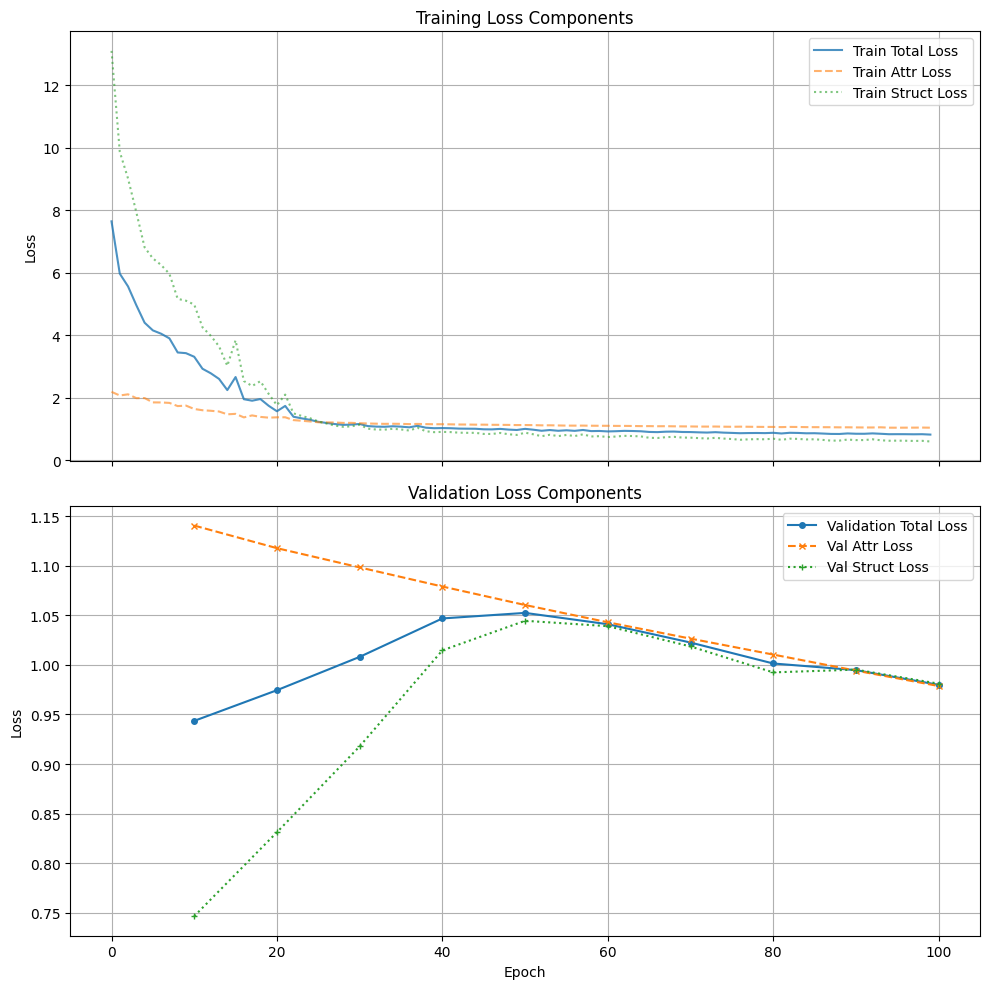

--- Training Finished ---


In [15]:
# Define training hyperparameters
num_epochs = 100
lambda_attr = 0.5
lambda_struct = 0.5 
k_neg = 5
eval_freq = 10 # Evaluate on validation set every 10 epochs
target_edge_type = ('provider', 'to', 'member')


trained_model, history = train_model_inductive(
    model=bgae_model,
    train_graph=train_g_on_device,
    num_epochs=num_epochs,
    optimizer=optimizer,
    lambda_attr=lambda_attr,
    lambda_struct=lambda_struct,
    k_neg_samples=k_neg,
    target_edge_type=target_edge_type,
    device=device, 
    val_graph=val_g_on_device,
    val_log_freq=eval_freq,
)
print("--- Training Finished ---")

In [16]:
# --- Calculate Anomaly Scores on Training and Validation Graphs ---
print("\n--- Calculating Anomaly Scores on Training and Validation Graphs ---")
# Use the same lambdas for scoring as for training loss weighting
node_scores_train, edge_scores_train = calculate_anomaly_scores(
    trained_model=trained_model,
    eval_graph_data=train_g_on_device,
    lambda_attr=lambda_attr,
    lambda_struct=lambda_struct,
    target_edge_type=target_edge_type
)

node_scores_val, edge_scores_val = calculate_anomaly_scores(
    trained_model=trained_model,
    eval_graph_data=val_g_on_device,
    lambda_attr=lambda_attr,
    lambda_struct=lambda_struct,
    target_edge_type=target_edge_type
)
print("--- Score Calculation Finished ---")

# --- Evaluate Performance on Training and Validation Graphs ---
print("\n--- Evaluating Performance on Training and Validation Graphs ---")
k_values_for_eval = [50, 100, 200, 500]

# Evaluate on Training Graph
results_train = evaluate_performance_inductive(
    node_scores=node_scores_train,
    edge_scores=edge_scores_train,
    gt_node_labels_eval=gt_node_labels_train,
    gt_edge_labels_eval=gt_edge_labels_dict_train,
    k_list=k_values_for_eval
)

# Evaluate on Validation Graph
results_val = evaluate_performance_inductive(
    node_scores=node_scores_val,
    edge_scores=edge_scores_val,
    gt_node_labels_eval=gt_node_labels_val,
    gt_edge_labels_eval=gt_edge_labels_dict_val,
    k_list=k_values_for_eval
)

# --- Display Results ---
print("\n--- Inductive Evaluation Results ---")

print("\nTraining Graph Node Results:")
df_node_results_train = pd.DataFrame(results_train['nodes']).T
display(df_node_results_train)

print("\nTraining Graph Edge Results:")
edge_results_train_str_keys = {str(k): v for k, v in results_train['edges'].items()}
df_edge_results_train = pd.DataFrame(edge_results_train_str_keys).T
display(df_edge_results_train)

print("\nValidation Graph Node Results:")
df_node_results_val = pd.DataFrame(results_val['nodes']).T
display(df_node_results_val)

print("\nValidation Graph Edge Results:")
edge_results_val_str_keys = {str(k): v for k, v in results_val['edges'].items()}
df_edge_results_val = pd.DataFrame(edge_results_val_str_keys).T
display(df_edge_results_val)

print("\n--- Analysis Complete ---")


--- Calculating Anomaly Scores on Training and Validation Graphs ---
Calculating self-supervised anomaly scores...
Anomaly score calculation finished.
Calculating self-supervised anomaly scores...
Anomaly score calculation finished.
--- Score Calculation Finished ---

--- Evaluating Performance on Training and Validation Graphs ---
--- Evaluating Performance on Scores ---
Evaluating Node Scores...
  Node Type: member - Items: 24420, Anomalies: 72
  Node Type: provider - Items: 489, Anomalies: 63
Evaluating Edge Scores...
  Edge Type: ('provider', 'to', 'member') - Items: 35633, Anomalies: 204
--- Evaluation Finished ---
--- Evaluating Performance on Scores ---
Evaluating Node Scores...
  Node Type: member - Items: 3256, Anomalies: 37
  Node Type: provider - Items: 65, Anomalies: 24
Evaluating Edge Scores...
  Edge Type: ('provider', 'to', 'member') - Items: 497, Anomalies: 107
--- Evaluation Finished ---

--- Inductive Evaluation Results ---

Training Graph Node Results:


,AUROC,AP,Best F1,Best F1 Threshold,Precision@50,Recall@50,Precision@100,Recall@100,Precision@200,Recall@200,Precision@500,Recall@500
member,0.738148,0.016926,0.072948,20.211729,0.02,0.013889,0.03,0.041667,0.045,0.125000,0.028000,0.194444
provider,0.590320,0.338728,0.428571,20.472443,0.46,0.365079,0.23,0.365079,0.145,0.460317,0.128834,1.000000



Training Graph Edge Results:


,AUROC,AP,Best F1,Best F1 Threshold
"('provider', 'to', 'member')",0.901792,0.198957,0.363636,8.880055



Validation Graph Node Results:


,AUROC,AP,Best F1,Best F1 Threshold,Precision@50,Recall@50,Precision@100,Recall@100,Precision@200,Recall@200,Precision@500,Recall@500
member,0.767588,0.093274,0.255319,16.652996,0.20,0.270270,0.130000,0.351351,0.065000,0.351351,0.038000,0.513514
provider,0.617886,0.569975,0.558140,3.307493,0.38,0.791667,0.369231,1.000000,0.369231,1.000000,0.369231,1.000000



Validation Graph Edge Results:


,AUROC,AP,Best F1,Best F1 Threshold
"('provider', 'to', 'member')",0.922765,0.843251,0.826531,8.70055



--- Analysis Complete ---


In [17]:
# --- Calculate Anomaly Scores on Test Graph ---
print("\n--- Calculating Anomaly Scores on Test Graph ---")
# Use the same lambdas for scoring as for training loss weighting
node_scores_test, edge_scores_test = calculate_anomaly_scores(
    trained_model=trained_model,
    eval_graph_data=test_g_on_device,
    lambda_attr=lambda_attr,
    lambda_struct=lambda_struct,
    target_edge_type=target_edge_type
)
print("--- Score Calculation Finished ---")

# --- Evaluate Performance on Test Graph ---
print("\n--- Evaluating Performance on Test Graph ---")
k_values_for_eval = [50, 100, 200, 500]

# Evaluate on Test Graph
results_test = evaluate_performance_inductive(
    node_scores=node_scores_test,
    edge_scores=edge_scores_test,
    gt_node_labels_eval=gt_node_labels_test,
    gt_edge_labels_eval=gt_edge_labels_dict_test,
    k_list=k_values_for_eval
)

# --- Display Results ---
print("\nTest Graph Node Results:")
df_node_results_test = pd.DataFrame(results_test['nodes']).T
display(df_node_results_test)

print("\nTest Graph Edge Results:")
edge_results_test_str_keys = {str(k): v for k, v in results_test['edges'].items()}
df_edge_results_test = pd.DataFrame(edge_results_test_str_keys).T
display(df_edge_results_test)

print("\n--- Test Graph Analysis Complete ---")


--- Calculating Anomaly Scores on Test Graph ---
Calculating self-supervised anomaly scores...
Anomaly score calculation finished.
--- Score Calculation Finished ---

--- Evaluating Performance on Test Graph ---
--- Evaluating Performance on Scores ---
Evaluating Node Scores...
  Node Type: member - Items: 4884, Anomalies: 30
  Node Type: provider - Items: 98, Anomalies: 27
Evaluating Edge Scores...
  Edge Type: ('provider', 'to', 'member') - Items: 1221, Anomalies: 41
--- Evaluation Finished ---

Test Graph Node Results:


,AUROC,AP,Best F1,Best F1 Threshold,Precision@50,Recall@50,Precision@100,Recall@100,Precision@200,Recall@200,Precision@500,Recall@500
member,0.671831,0.045793,0.178218,19.058935,0.12,0.20000,0.09000,0.3,0.06000,0.4,0.02400,0.4
provider,0.673448,0.540819,0.494845,4.753881,0.34,0.62963,0.27551,1.0,0.27551,1.0,0.27551,1.0



Test Graph Edge Results:


,AUROC,AP,Best F1,Best F1 Threshold
"('provider', 'to', 'member')",0.859343,0.302362,0.453333,8.560734



--- Test Graph Analysis Complete ---


--- Starting Inductive Model Evaluation (with Anomaly Type Analysis) ---

--- Scoring Phase ---
Calculating scores for train split...
Calculating self-supervised anomaly scores...
Anomaly score calculation finished.
Calculating scores for val split...
Calculating self-supervised anomaly scores...
Anomaly score calculation finished.
Calculating scores for test split...
Calculating self-supervised anomaly scores...
Anomaly score calculation finished.
--- Scoring Complete ---

--- Evaluation Phase ---

Evaluating performance for train split...
  Overall Node Metrics (train, member): AUROC=0.740, AP=0.017
    Analyzing 9 unique anomaly tags for member...
  Overall Node Metrics (train, provider): AUROC=0.590, AP=0.339
    Analyzing 7 unique anomaly tags for provider...
  Overall Edge Metrics (train, ('provider', 'to', 'member')): AUROC=0.902, AP=0.199

Evaluating performance for val split...
  Overall Node Metrics (val, member): AUROC=0.768, AP=0.093
    Analyzing 9 unique anomaly tags for 

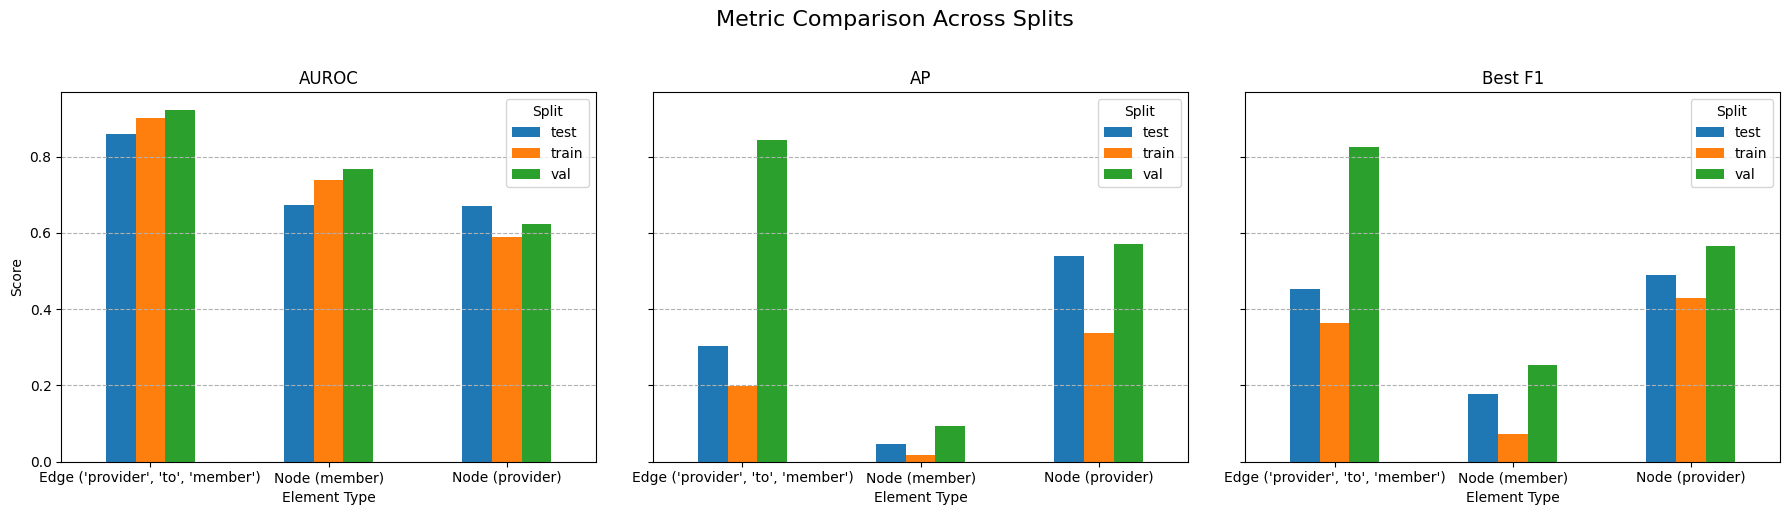

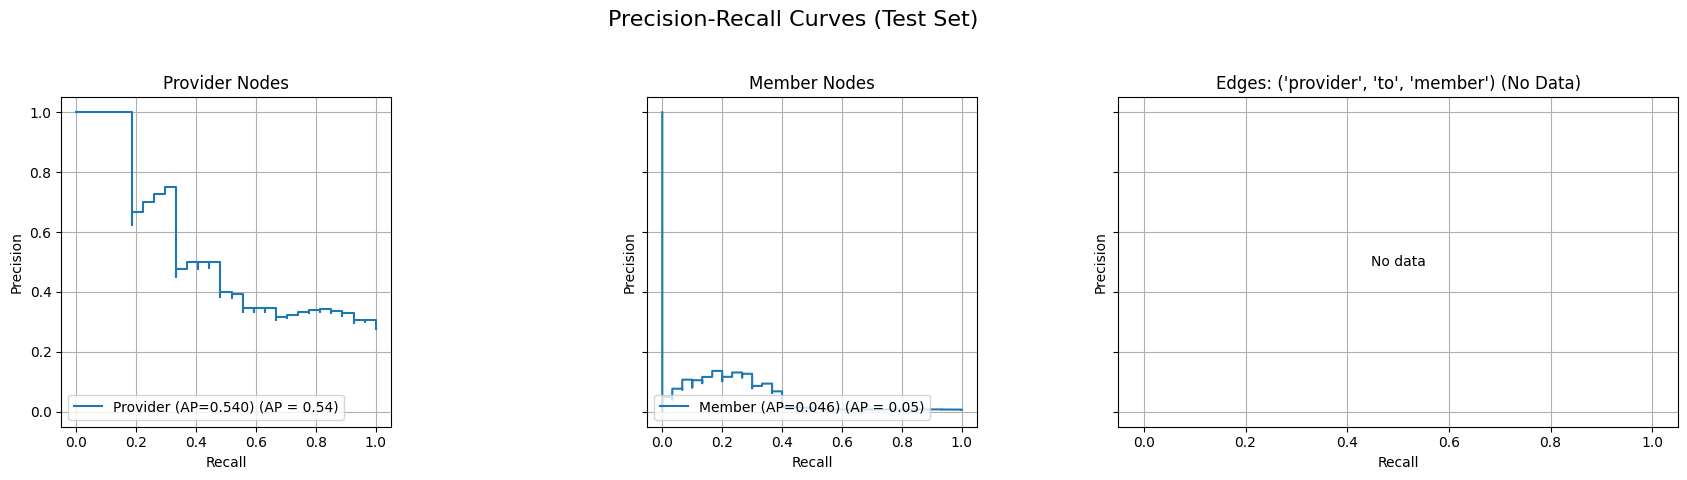

/Users/karimchakroun/degree-project-gad-healthcare/notebooks/../src/utils/eval_utils.py:622: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_plot, x='Anomaly', y='Score', ax=ax, palette='viridis', order=['Normal', 'Anomaly'])
/Users/karimchakroun/degree-project-gad-healthcare/notebooks/../src/utils/eval_utils.py:622: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_plot, x='Anomaly', y='Score', ax=ax, palette='viridis', order=['Normal', 'Anomaly'])


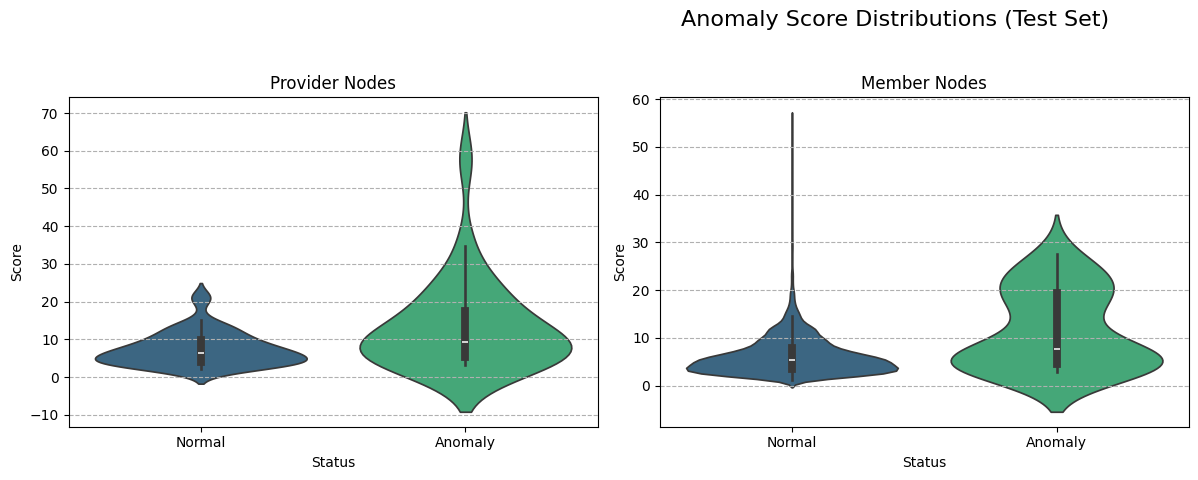

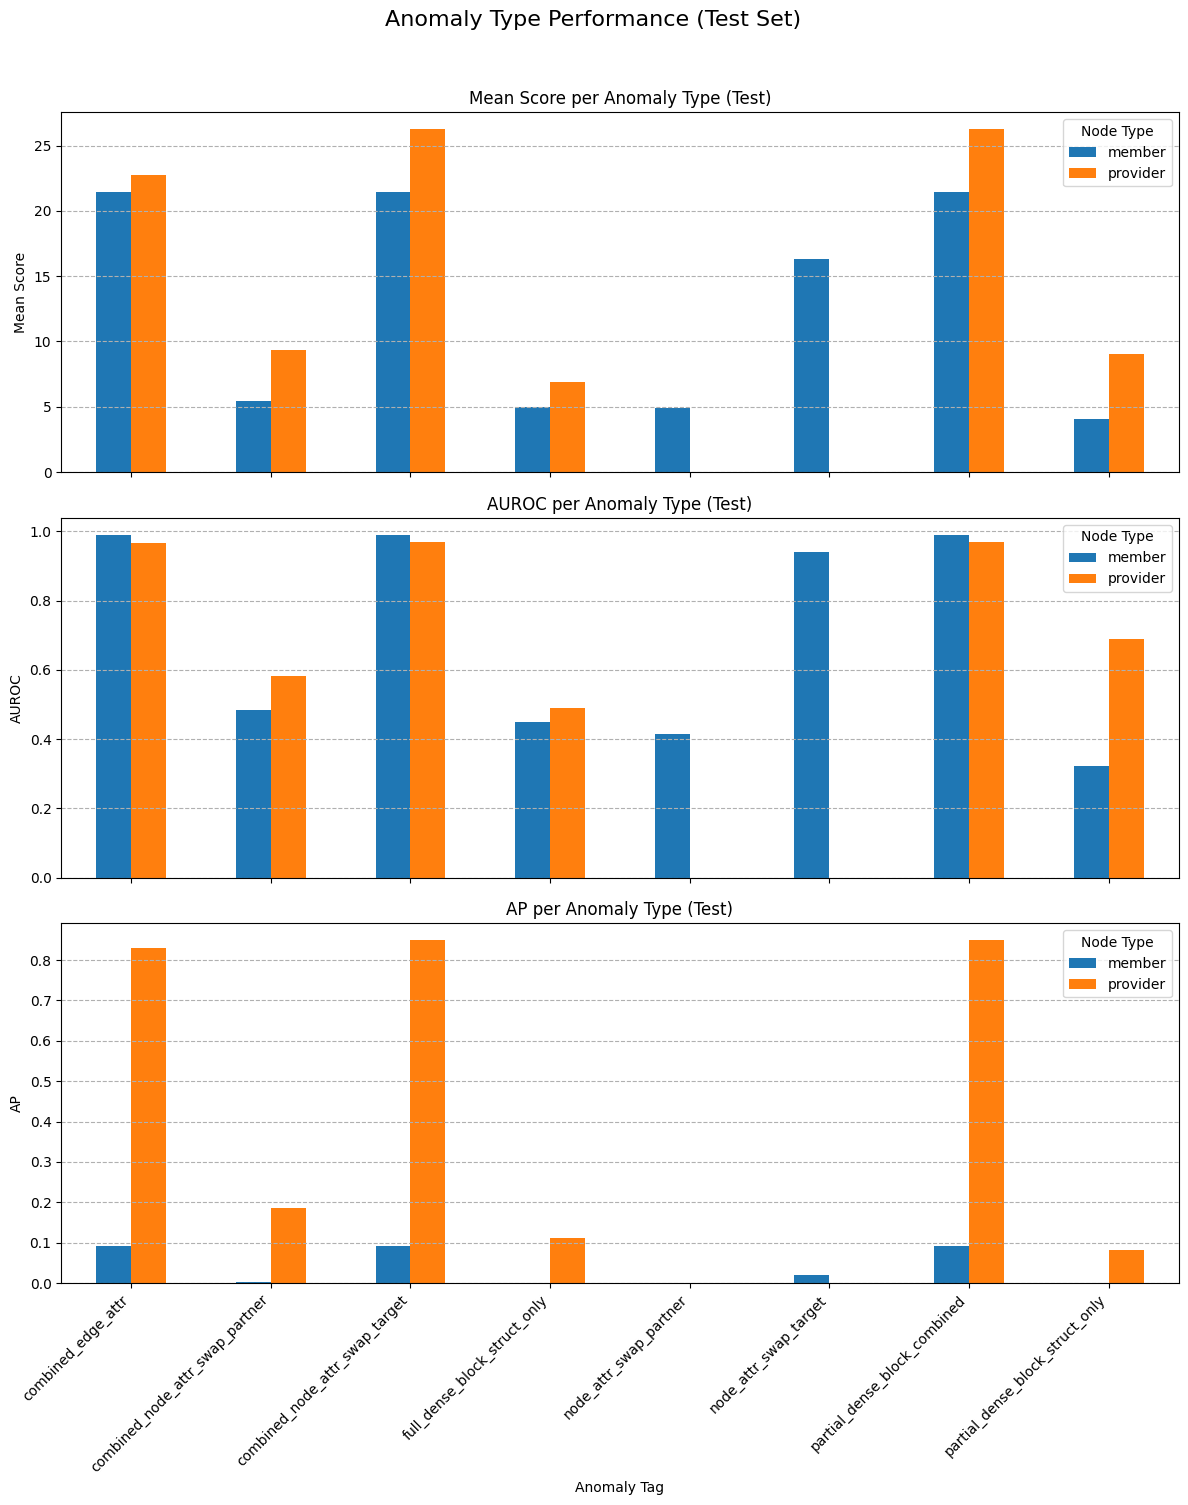

--- Evaluation Function Finished ---

--- Overall Metrics Summary ---


,Split,Element,Num Items,Num Anomalies,% Anomalies,AUROC,AP,Best F1,Best F1 Threshold,Precision@50,Recall@50,Precision@100,Recall@100,Precision@200,Recall@200,Precision@500,Recall@500
0,train,Node (member),24420,72,0.294840,0.739733,0.016594,0.072727,20.161776,0.02,0.013889,0.030000,0.041667,0.045000,0.125000,0.030000,0.208333
1,train,Node (provider),489,63,12.883436,0.590320,0.338676,0.428571,20.465755,0.46,0.365079,0.230000,0.365079,0.145000,0.460317,0.128834,1.000000
2,train,"Edge ('provider', 'to', 'member')",35633,204,0.572503,0.901792,0.198957,0.363636,8.880055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,val,Node (member),3256,37,1.136364,0.767764,0.093103,0.252632,16.652996,0.20,0.270270,0.130000,0.351351,0.065000,0.351351,0.038000,0.513514
4,val,Node (provider),65,24,36.923077,0.623984,0.571024,0.564706,3.312673,0.38,0.791667,0.369231,1.000000,0.369231,1.000000,0.369231,1.000000
5,val,"Edge ('provider', 'to', 'member')",497,107,21.529175,0.922765,0.843251,0.826531,8.700550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,test,Node (member),4884,30,0.614251,0.673589,0.045938,0.178218,19.138779,0.12,0.200000,0.090000,0.300000,0.060000,0.400000,0.024000,0.400000
7,test,Node (provider),98,27,27.551020,0.671883,0.540362,0.490566,11.040626,0.34,0.629630,0.275510,1.000000,0.275510,1.000000,0.275510,1.000000
8,test,"Edge ('provider', 'to', 'member')",1221,41,3.357903,0.859343,0.302362,0.453333,8.560734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



--- Anomaly Type Performance Summary ---


,Split,Node Type,Anomaly Tag,Count,Mean Score,Median Score,AUROC,AP,Best F1
0,train,member,combined_edge_attr,24,16.196779,15.875008,0.909226,0.015912,0.051948
1,train,member,partial_dense_block_combined,16,15.284184,14.722027,0.876278,0.009300,0.033670
2,train,member,combined_node_attr_swap_partner,17,8.704668,6.506230,0.585699,0.002459,0.034483
3,train,member,node_attr_swap_target,8,18.449852,15.068832,0.969844,0.009370,0.032967
4,train,member,partial_dense_block_struct_only,7,9.971698,9.459463,0.738893,0.001164,0.007874
5,train,member,full_dense_block_combined,8,18.021969,17.492197,0.975121,0.009059,0.027778
6,train,member,combined_node_attr_swap_target,17,18.612270,17.195055,0.975662,0.017947,0.046667
7,train,member,node_attr_swap_partner,8,6.166772,5.729773,0.501422,0.000377,0.000912
8,train,member,full_dense_block_struct_only,8,7.064939,6.550668,0.567516,0.000471,0.001467
9,train,provider,full_dense_block_combined,9,31.378296,32.687763,0.982786,0.450153,0.636364


In [18]:
from src.utils.eval_utils import *
ev_params = {
    "k_list": [50, 100, 200, 500],
    "lambda_attr": lambda_attr,
    "lambda_struct": lambda_struct,
    "k_neg_samples": k_neg,
}
all_scores, summary_df, anomaly_type_df = evaluate_model_inductively(
    trained_model=trained_model,
    train_graph=train_g,
    val_graph=val_g,
    test_graph=test_g,
    gt_node_labels=GT_NODE_LABELS,
    gt_edge_labels=GT_EDGE_LABELS,
    anomaly_tracking_all=ANOMALY_TRACKING, 
    device=device,
    eval_params=ev_params,
    target_edge_type=target_edge_type,
    plot=True,
    verbose=True
)

print("\n--- Overall Metrics Summary ---")
display(summary_df)

print("\n--- Anomaly Type Performance Summary ---")
display(anomaly_type_df)

### 4.2 Baseline Models

#### 4.2.1 Feature-based baseline models

In [47]:
# Add necessary imports (should already be there from previous step)
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, average_precision_score
from src.utils.baseline_utils import *


train_graph = train_g.clone()
val_graph = val_g.clone()
test_graph = test_g.clone()

# --- 1. Augment Features for Each Split  ---
print("Augmenting features for train, val, and test splits...")
augmented_features_train = augment_features_for_sklearn(train_graph)
augmented_features_val = augment_features_for_sklearn(val_graph)
augmented_features_test = augment_features_for_sklearn(test_graph)
print("Feature augmentation complete.")

# --- Initialize results storage ---
results_baselines_separate = {} # Stores scores per model, split, type
eval_summary_separate = []      # Stores evaluation metrics
k_list_baselines = [50, 100, 200] # Or define elsewhere

# --- 2. Loop through Node Types for Separate Training and Evaluation ---
for node_type in ['provider', 'member']:
    print(f"\n--- Processing Node Type: {node_type} ---")

    # --- 2a. Extract Features and Labels for this Node Type ---
    print(f"  Extracting {node_type} features and labels...")
    try:
        X_train_nt = augmented_features_train[node_type]
        y_train_nt = gt_node_labels_train[node_type].cpu().numpy()

        X_val_nt = augmented_features_val[node_type]
        y_val_nt = gt_node_labels_val[node_type].cpu().numpy()

        X_test_nt = augmented_features_test[node_type]
        y_test_nt = gt_node_labels_test[node_type].cpu().numpy()

        # Basic validation
        if not (X_train_nt.shape[0] == y_train_nt.shape[0] and
                X_val_nt.shape[0] == y_val_nt.shape[0] and
                X_test_nt.shape[0] == y_test_nt.shape[0]):
            raise ValueError("Feature/label shape mismatch for a split.")

        if X_train_nt.shape[0] == 0:
             print(f"  Skipping {node_type}: No training data found.")
             continue

    except (KeyError, ValueError) as e:
        print(f"  Skipping {node_type}: Error extracting data - {e}")
        continue

    print(f"    Train shape: {X_train_nt.shape}")
    print(f"    Val shape: {X_val_nt.shape}")
    print(f"    Test shape: {X_test_nt.shape}")

    # --- 2b. Preprocess (Scale) Features ---
    print(f"  Scaling {node_type} features...")
    scaler_nt = StandardScaler()
    X_train_scaled_nt = scaler_nt.fit_transform(X_train_nt)
    # Handle cases where val/test might be empty for this node type
    X_val_scaled_nt = scaler_nt.transform(X_val_nt) if X_val_nt.shape[0] > 0 else X_val_nt
    X_test_scaled_nt = scaler_nt.transform(X_test_nt) if X_test_nt.shape[0] > 0 else X_test_nt
    print("    Scaling complete.")

    # --- 2c. Define and Train Baseline Models ---
    print(f"  Training baseline models for {node_type}...")
    contamination_est_nt = y_train_nt.mean()
    print(f"    Estimated contamination ({node_type}): {contamination_est_nt:.4f}")

    models_nt = {}
    # Isolation Forest
    iforest_nt = IsolationForest(contamination=contamination_est_nt, random_state=42)
    iforest_nt.fit(X_train_scaled_nt)
    models_nt['IsolationForest'] = iforest_nt
    print("    Isolation Forest trained.")

    # One-Class SVM
    ocsvm_nt = OneClassSVM(nu=max(0.01, min(0.99, contamination_est_nt)), kernel='rbf', gamma='auto') # Ensure nu in (0, 1)
    ocsvm_nt.fit(X_train_scaled_nt)
    models_nt['OneClassSVM'] = ocsvm_nt
    print("    One-Class SVM trained.")
    print(f"    Baseline training for {node_type} complete.")

    # --- 2d. Predict/Score Anomalies ---
    print(f"  Generating anomaly scores for {node_type}...")
    if node_type not in results_baselines_separate:
        results_baselines_separate[node_type] = {}

    for model_name, model in models_nt.items():
        if model_name not in results_baselines_separate[node_type]:
            results_baselines_separate[node_type][model_name] = {}

        scores_train_nt = model.decision_function(X_train_scaled_nt)
        # Handle potentially empty val/test splits
        scores_val_nt = model.decision_function(X_val_scaled_nt) if X_val_scaled_nt.shape[0] > 0 else np.array([])
        scores_test_nt = model.decision_function(X_test_scaled_nt) if X_test_scaled_nt.shape[0] > 0 else np.array([])

        # Negate scores
        scores_train_nt = -scores_train_nt
        scores_val_nt = -scores_val_nt
        scores_test_nt = -scores_test_nt

        results_baselines_separate[node_type][model_name]['train'] = {'scores': scores_train_nt, 'labels': y_train_nt}
        results_baselines_separate[node_type][model_name]['val'] = {'scores': scores_val_nt, 'labels': y_val_nt}
        results_baselines_separate[node_type][model_name]['test'] = {'scores': scores_test_nt, 'labels': y_test_nt}
    print(f"    Scoring for {node_type} complete.")

    # --- 2e. Evaluate ---
    print(f"  Evaluating baseline models for {node_type}...")
    for model_name, split_results in results_baselines_separate[node_type].items():
        print(f"    Model: {model_name}")
        for split_name, data in split_results.items():
            scores = data['scores']
            labels = data['labels']

            if len(scores) == 0:
                print(f"      Split: {split_name} - No data to evaluate.")
                continue

            print(f"      Split: {split_name} - Items: {len(scores)}, Anomalies: {int(np.sum(labels))}")
            metrics = compute_evaluation_metrics(scores, labels, k_list=k_list_baselines)

            summary_row = {
                'Model': model_name,
                'Split': split_name,
                'Element': f'Node ({node_type})', # Store node type info
                'Num Items': len(scores),
                'Num Anomalies': int(np.sum(labels)),
                '% Anomalies': (np.sum(labels) / len(scores) * 100) if len(scores) > 0 else 0
            }
            summary_row.update(metrics)
            eval_summary_separate.append(summary_row)

            # Print key metrics
            print(f"        AUROC: {metrics.get('AUROC', 0.0):.4f}, AP: {metrics.get('AP', 0.0):.4f}, Best F1: {metrics.get('Best F1', 0.0):.4f}")

# --- 3. Display Combined Results ---
baseline_summary_df_separate = pd.DataFrame(eval_summary_separate)
# Reorder columns for clarity
ordered_cols = ['Model', 'Split', 'Element', 'Num Items', 'Num Anomalies', '% Anomalies',
               'AUROC', 'AP', 'Best F1', 'Best F1 Threshold'] + \
               [f'{p}@{k}' for k in k_list_baselines for p in ['Precision', 'Recall']]
# Ensure only existing columns are used for reindexing
existing_cols_ordered = [col for col in ordered_cols if col in baseline_summary_df_separate.columns]
baseline_summary_df_separate = baseline_summary_df_separate.reindex(columns=existing_cols_ordered, fill_value=np.nan)


print("\n--- Baseline Evaluation Summary (Separate Models) ---")
# Increase display options for pandas DataFrame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
print(baseline_summary_df_separate.to_string())
print("Baseline evaluation complete.")

# Reset display options if desired
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')


# Store the final summary DataFrame
# all_model_summaries['FeatureBasedSeparate'] = baseline_summary_df_separate

Augmenting features for train, val, and test splits...
Device for augmentation: mps:0
Device for augmentation: mps:0
Device for augmentation: mps:0
Feature augmentation complete.

--- Processing Node Type: provider ---
  Extracting provider features and labels...
    Train shape: (489, 44)
    Val shape: (65, 44)
    Test shape: (98, 44)
  Scaling provider features...
    Scaling complete.
  Training baseline models for provider...
    Estimated contamination (provider): 0.1288
    Isolation Forest trained.
    One-Class SVM trained.
    Baseline training for provider complete.
  Generating anomaly scores for provider...
    Scoring for provider complete.
  Evaluating baseline models for provider...
    Model: IsolationForest
      Split: train - Items: 489, Anomalies: 63
        AUROC: 0.6429, AP: 0.2478, Best F1: 0.3562
      Split: val - Items: 65, Anomalies: 24
        AUROC: 0.5539, AP: 0.5448, Best F1: 0.5393
      Split: test - Items: 98, Anomalies: 27
        AUROC: 0.6093, AP:

#### 4.2.2 Structure-based Baseline models (GAE and OddBall)

In [ ]:
###### GAE

##### ODDBALL

In [44]:
from src.external_repos.OddBall.egonet_extractor import EgonetFeatureExtractor
from src.external_repos.OddBall.utils import select_group_nodes, get_node_property_list
from src.external_repos.OddBall.anomaly_detection import (
        StarCliqueAnomalyDetection, HeavyVicinityAnomalyDetection, DominantEdgeAnomalyDetection,
        StarCliqueLOFAnomalyDetection, HeavyVicinityLOFAnomalyDetection, DominantEdgeLOFAnomalyDetection
    )
from src.external_repos.OddBall.oddball_runner import *


In [ ]:
# --- OddBall Baseline Evaluation ---
print("\n--- Starting OddBall Baseline Evaluation ---")

# Define OddBall parameters
oddball_anomaly_type = 'sc' # Options: 'sc', 'hv', 'de'
oddball_use_lof = False     # Keep False for simplicity first

oddball_results_list = []
k_list_baselines = [50, 100, 200] # Use same K as other baselines

graphs_dict = {'train': train_g, 'val': val_g, 'test': test_g} # Assuming these are your splits

for split_name, graph_split in graphs_dict.items():
    print(f"\n===== Processing Split: {split_name} =====")
    gt_labels_split = GT_NODE_LABELS[split_name] # Get the GT labels for this split

    for node_type in ['provider', 'member']:
         # Check if node type exists in this split
         if node_type not in graph_split.node_types or graph_split[node_type].num_nodes == 0:
             print(f"Skipping Oddball for {node_type} in {split_name} split (no nodes).")
             continue

         # Run and evaluate OddBall for this node type
         metrics = evaluate_oddball_inductive(
             graph_split=graph_split,
             gt_node_labels_split=gt_labels_split,
             anomaly_type=oddball_anomaly_type,
             node_type_to_eval=node_type,
             use_lof=oddball_use_lof,
             k_list=k_list_baselines
         )

         if metrics: # Check if evaluation was successful
             num_items = graph_split[node_type].num_nodes
             num_anomalies = int(gt_labels_split.get(node_type, torch.tensor([])).sum().item())
             perc = (num_anomalies / num_items * 100) if num_items > 0 else 0
             summary_row = {
                 'Model': f'OddBall ({oddball_anomaly_type}, LOF={oddball_use_lof})',
                 'Split': split_name,
                 'Element': f'Node ({node_type})',
                 'Num Items': num_items,
                 'Num Anomalies': num_anomalies,
                 '% Anomalies': perc
             }
             summary_row.update(metrics)
             oddball_results_list.append(summary_row)
         else:
              print(f"OddBall evaluation failed for {node_type} in {split_name} split.")


# --- Display OddBall Results ---
if oddball_results_list:
    oddball_summary_df = pd.DataFrame(oddball_results_list)
    # Reorder columns for clarity (similar to other baselines)
    ordered_cols = ['Model', 'Split', 'Element', 'Num Items', 'Num Anomalies', '% Anomalies',
                   'AUROC', 'AP', 'Best F1', 'Best F1 Threshold'] + \
                   [f'{p}@{k}' for k in k_list_baselines for p in ['Precision', 'Recall']]
    existing_cols_ordered = [col for col in ordered_cols if col in oddball_summary_df.columns]
    oddball_summary_df = oddball_summary_df.reindex(columns=existing_cols_ordered, fill_value=np.nan)

    print("\n--- OddBall Evaluation Summary ---")
    # Increase display options for pandas DataFrame
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 50)
    pd.set_option('display.width', 1000)
    print(oddball_summary_df.to_string())
else:
    print("\n--- No OddBall results were generated. ---")

# You can now combine oddball_summary_df with your other baseline DataFrames
# (e.g., baseline_summary_df_separate) for a complete comparison table.
# Example: combined_summary = pd.concat([baseline_summary_df_separate, oddball_summary_df], ignore_index=True)


--- Starting OddBall Baseline Evaluation ---

===== Processing Split: train =====

--- Evaluating OddBall (sc, LOF=False) for Node Type: provider ---
num_src_nodes: 489, num_dst_nodes: 24420
Converted HeteroData to nx.Graph: 24909 nodes (489 provider, 24420 member), 35633 edges.
Running OddBall: type=sc, group=0, lof=False
Finding features


100%|██████████| 24909/24909 [00:19<00:00, 1287.16it/s]


Time used for feature finding: 27.446577072143555
Instantiating detector...
Detecting anomalies for group 0...
Filtered node list from: 489 to 489
Fitted power law:
	alpha: 0.9999999999999991
	beta: 2.6645352591003757e-15
OddBall processed 489 nodes in group 0.
Mapped 489 non-zero scores out of 489 total nodes for group 0.
Returning final score dictionary with 489 entries.
Mapped 489 scores to array of size 489.
Computing metrics for provider...

--- Evaluating OddBall (sc, LOF=False) for Node Type: member ---
num_src_nodes: 489, num_dst_nodes: 24420
Converted HeteroData to nx.Graph: 24909 nodes (489 provider, 24420 member), 35633 edges.
Running OddBall: type=sc, group=1, lof=False
Finding features


100%|██████████| 24909/24909 [00:19<00:00, 1291.31it/s]


Time used for feature finding: 27.153328895568848
Instantiating detector...
Detecting anomalies for group 1...
Filtered node list from: 24420 to 21503
Fitted power law:
	alpha: 1.0000000000000164
	beta: -6.439293542825908e-15
OddBall processed 21503 nodes in group 1.
Mapped 21503 non-zero scores out of 24420 total nodes for group 1.
Returning final score dictionary with 24420 entries.
Mapped 24420 scores to array of size 24420.
Computing metrics for member...

===== Processing Split: val =====

--- Evaluating OddBall (sc, LOF=False) for Node Type: provider ---
num_src_nodes: 65, num_dst_nodes: 3256
Converted HeteroData to nx.Graph: 3321 nodes (65 provider, 3256 member), 497 edges.
Running OddBall: type=sc, group=0, lof=False
Finding features


100%|██████████| 3321/3321 [00:00<00:00, 2604578.08it/s]


Time used for feature finding: 0.4850270748138428
Instantiating detector...
Detecting anomalies for group 0...
Filtered node list from: 65 to 58
Fitted power law:
	alpha: 0.9999999999999996
	beta: 6.661338147750939e-16
OddBall processed 58 nodes in group 0.
Mapped 58 non-zero scores out of 65 total nodes for group 0.
Returning final score dictionary with 65 entries.
Mapped 65 scores to array of size 65.
Computing metrics for provider...

--- Evaluating OddBall (sc, LOF=False) for Node Type: member ---
num_src_nodes: 65, num_dst_nodes: 3256
Converted HeteroData to nx.Graph: 3321 nodes (65 provider, 3256 member), 497 edges.
Running OddBall: type=sc, group=1, lof=False
Finding features


100%|██████████| 3321/3321 [00:00<00:00, 3451259.56it/s]


Time used for feature finding: 0.4274299144744873
Instantiating detector...
Detecting anomalies for group 1...
Filtered node list from: 3256 to 388
Fitted power law:
	alpha: 0.9999999999999992
	beta: 9.71445146547012e-17
OddBall processed 388 nodes in group 1.
Mapped 388 non-zero scores out of 3256 total nodes for group 1.
Returning final score dictionary with 3256 entries.
Mapped 3256 scores to array of size 3256.
Computing metrics for member...

===== Processing Split: test =====

--- Evaluating OddBall (sc, LOF=False) for Node Type: provider ---
num_src_nodes: 98, num_dst_nodes: 4884
Converted HeteroData to nx.Graph: 4982 nodes (98 provider, 4884 member), 1221 edges.
Running OddBall: type=sc, group=0, lof=False
Finding features


100%|██████████| 4982/4982 [00:00<00:00, 4189258.73it/s]


Time used for feature finding: 0.5683262348175049
Instantiating detector...
Detecting anomalies for group 0...
Filtered node list from: 98 to 96
Fitted power law:
	alpha: 1.0
	beta: 0.0
OddBall processed 96 nodes in group 0.
Mapped 96 non-zero scores out of 98 total nodes for group 0.
Returning final score dictionary with 98 entries.
Mapped 98 scores to array of size 98.
Computing metrics for provider...

--- Evaluating OddBall (sc, LOF=False) for Node Type: member ---
num_src_nodes: 98, num_dst_nodes: 4884
Converted HeteroData to nx.Graph: 4982 nodes (98 provider, 4884 member), 1221 edges.
Running OddBall: type=sc, group=1, lof=False
Finding features


100%|██████████| 4982/4982 [00:00<00:00, 4826986.03it/s]


Time used for feature finding: 0.5695559978485107
Instantiating detector...
Detecting anomalies for group 1...
Filtered node list from: 4884 to 1096
Fitted power law:
	alpha: 1.0000000000000018
	beta: -1.249000902703301e-16
OddBall processed 1096 nodes in group 1.
Mapped 1096 non-zero scores out of 4884 total nodes for group 1.
Returning final score dictionary with 4884 entries.
Mapped 4884 scores to array of size 4884.
Computing metrics for member...

--- OddBall Evaluation Summary ---
                     Model  Split          Element  Num Items  Num Anomalies  % Anomalies     AUROC        AP   Best F1  Best F1 Threshold  Precision@50  Recall@50  Precision@100  Recall@100  Precision@200  Recall@200
0  OddBall (sc, LOF=False)  train  Node (provider)        489             63    12.883436  0.542291  0.146681  0.247619           0.000391          0.10   0.079365       0.100000    0.158730       0.145000    0.460317
1  OddBall (sc, LOF=False)  train    Node (member)      24420           

#### 4.2.3 Hybrid methods (DOMINANT)

In [40]:
print(graphs_dict["train"]["provider"].num_nodes)

489


# Old Code

In [ ]:
# --- 1. Split Edges for Structure Evaluation ---
print("--- Splitting Edges for Train/Validation/Test ---")
# Use the data that has anomalies injected
data_to_split = anomaly_data.clone() # Clone to prevent modifying the main anomaly_data object
target_edge_type = ('provider', 'to', 'member')
reverse_edge_type = ('member', 'to', 'provider') # Define if used by splitter

# Check if reverse edge type exists before passing it
rev_edge_types_arg = reverse_edge_type if reverse_edge_type in data_to_split.edge_types else None

edge_splitter = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    #is_undirected=True,
    add_negative_train_samples=False, # We handle negative sampling in the loop
    edge_types=[target_edge_type], # Specify edge type(s) to split
    rev_edge_types = [rev_edge_types_arg] if rev_edge_types_arg else None # Pass reverse type if exists
)

train_data, val_data, test_data = edge_splitter(data_to_split.to(device))

--- Splitting Edges for Train/Validation/Test ---


In [38]:
display(train_data)
display(val_data)  
display(test_data)

HeteroData(
  member={ x=[32560, 23] },
  provider={ x=[652, 38] },
  (provider, to, member)={
    edge_index=[2, 47410],
    edge_attr=[47410, 1],
    y=[47410],
    edge_label=[47410],
    edge_label_index=[2, 47410],
  },
  (member, to, provider)={
    edge_index=[2, 47410],
    edge_attr=[47410, 1],
    y=[47410],
  }
)

HeteroData(
  member={ x=[32560, 23] },
  provider={ x=[652, 38] },
  (provider, to, member)={
    edge_index=[2, 47410],
    edge_attr=[47410, 1],
    y=[47410],
    edge_label=[11852],
    edge_label_index=[2, 11852],
  },
  (member, to, provider)={
    edge_index=[2, 47410],
    edge_attr=[47410, 1],
    y=[47410],
  }
)

HeteroData(
  member={ x=[32560, 23] },
  provider={ x=[652, 38] },
  (provider, to, member)={
    edge_index=[2, 53336],
    edge_attr=[53336, 1],
    y=[53336],
    edge_label=[11852],
    edge_label_index=[2, 11852],
  },
  (member, to, provider)={
    edge_index=[2, 53336],
    edge_attr=[53336, 1],
    y=[53336],
  }
)

## 4. Train and Evaluate Models

--- Splitting Edges for Train/Validation/Test ---
Restoring node features to splits...
Train Data Sample: HeteroData(
  member={ x=[32560, 23] },
  provider={ x=[652, 38] },
  (provider, to, member)={
    edge_index=[2, 47410],
    edge_attr=[47410, 1],
    y=[47410],
    edge_label=[47410],
    edge_label_index=[2, 47410],
  },
  (member, to, provider)={
    edge_index=[2, 47410],
    edge_attr=[47410, 1],
    y=[47410],
  }
)
Validation Data Sample: HeteroData(
  member={ x=[32560, 23] },
  provider={ x=[652, 38] },
  (provider, to, member)={
    edge_index=[2, 47410],
    edge_attr=[47410, 1],
    y=[47410],
    edge_label=[11852],
    edge_label_index=[2, 11852],
  },
  (member, to, provider)={
    edge_index=[2, 47410],
    edge_attr=[47410, 1],
    y=[47410],
  }
)
Test Data Sample: HeteroData(
  member={ x=[32560, 23] },
  provider={ x=[652, 38] },
  (provider, to, member)={
    edge_index=[2, 53336],
    edge_attr=[53336, 1],
    y=[53336],
    edge_label=[11852],
    edge_labe

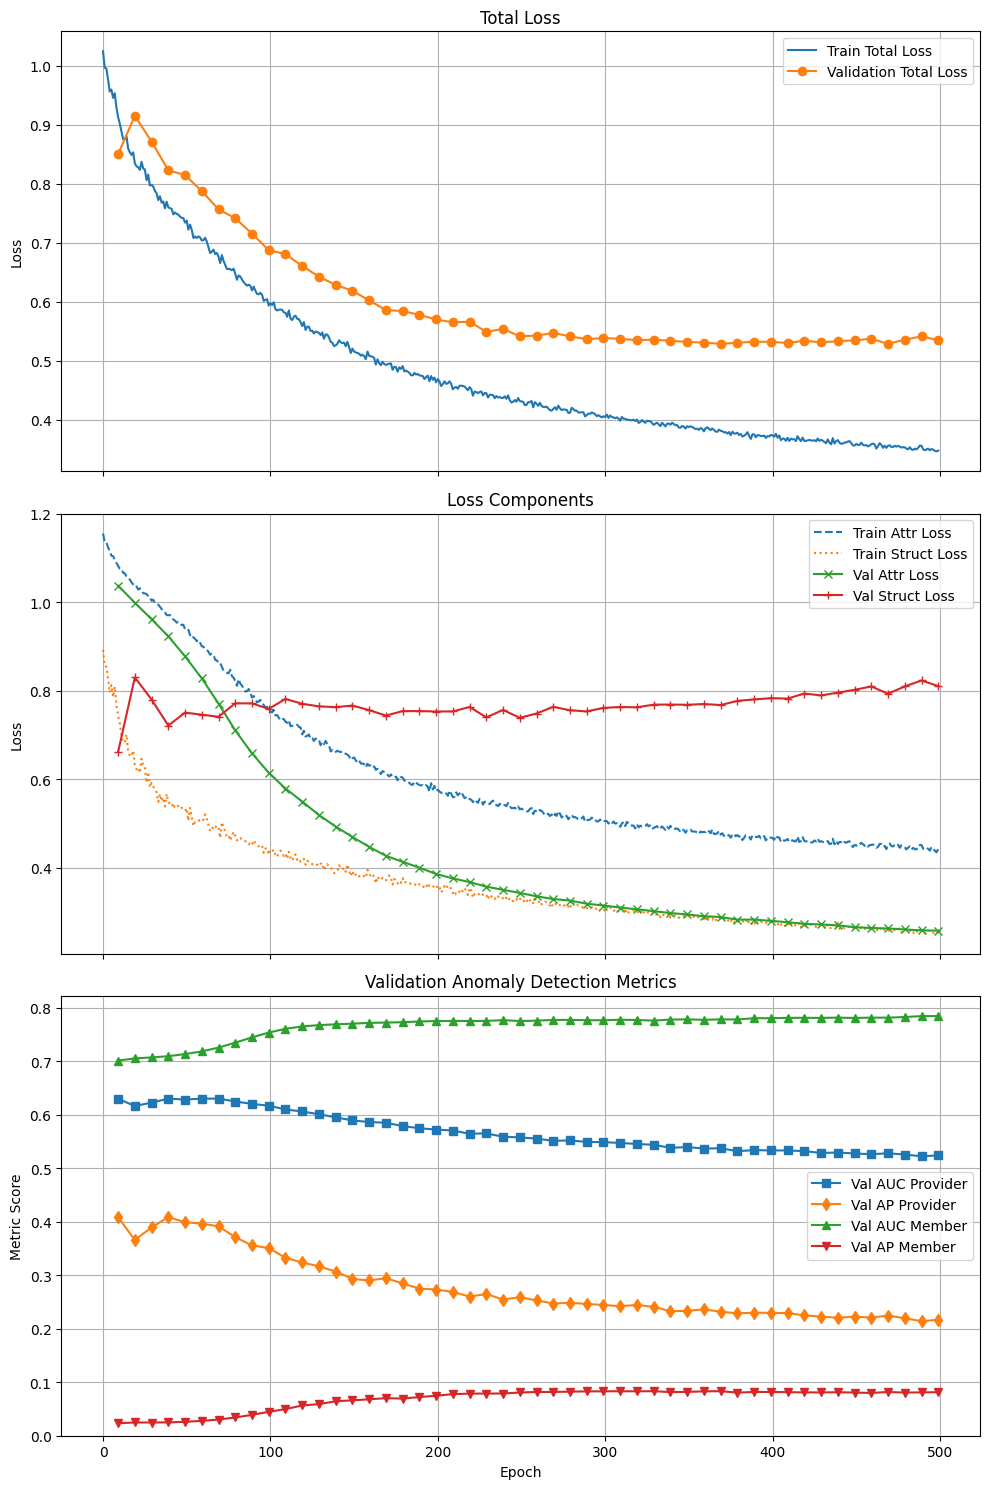


--- Starting Final Evaluation ---

--- Evaluating on Validation Set ---

Validation Results:


,AUROC,AP,Precision@50,Recall@50,Precision@100,Recall@100,Precision@200,Recall@200,Precision@500,Recall@500,Best F1,Best F1 Threshold
provider,0.436293,0.147048,0.14,0.081395,0.12,0.139535,0.090,0.209302,0.12,0.697674,0.233062,1.198067
member,0.836118,0.224892,0.48,0.235294,0.31,0.303922,0.185,0.362745,0.09,0.441176,0.339623,11.196568



--- Evaluating on Test Set ---

Test Results:


,AUROC,AP,Precision@50,Recall@50,Precision@100,Recall@100,Precision@200,Recall@200,Precision@500,Recall@500,Best F1,Best F1 Threshold
provider,0.436293,0.147048,0.14,0.081395,0.12,0.139535,0.090,0.209302,0.12,0.697674,0.233062,1.198066
member,0.836118,0.224892,0.48,0.235294,0.31,0.303922,0.185,0.362745,0.09,0.441176,0.339623,11.196569


In [ ]:
# --- 1. Split Edges for Structure Evaluation ---
print("--- Splitting Edges for Train/Validation/Test ---")
# Use the data that has anomalies injected
data_to_split = anomaly_data.clone() # Clone to prevent modifying the main anomaly_data object
target_edge_type = ('provider', 'to', 'member')
reverse_edge_type = ('member', 'to', 'provider') # Define if used by splitter

# Check if reverse edge type exists before passing it
rev_edge_types_arg = reverse_edge_type if reverse_edge_type in data_to_split.edge_types else None

edge_splitter = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    #is_undirected=False,
    add_negative_train_samples=False, # We handle negative sampling in the loop
    edge_types=[target_edge_type], # Specify edge type(s) to split
    rev_edge_types = [rev_edge_types_arg] if rev_edge_types_arg else None # Pass reverse type if exists
)

train_data, val_data, test_data = edge_splitter(data_to_split.to(device))

# Restore necessary attributes (like node features 'x') if dropped by splitter
# Important: RandomLinkSplit primarily modifies edge_index and adds edge_label info.
# Node features should ideally be preserved, but we copy them just in case.
print("Restoring node features to splits...")
for split in [train_data, val_data, test_data]:
    for node_type in data_to_split.node_types:
        if hasattr(data_to_split[node_type], 'x'):
            split[node_type].x = data_to_split[node_type].x
    # We don't restore edge_attr here, as RandomLinkSplit modifies edges.
    # The model's BipartiteAttentionConv handles missing edge_attr if edge_dim=0.
    # If edge_dim > 0, ensure the original `anomaly_data` passed to training/eval has it.

print("Train Data Sample:", train_data)
print("Validation Data Sample:", val_data)
print("Test Data Sample:", test_data)


# --- 2. Train and Validate the Model ---
print("\n--- Starting Training & Validation ---")
# Make sure the train_and_validate_model function is defined above

# Define training hyperparameters
num_epochs = 500 # ADJUST AS NEEDED (start lower, increase based on plots)
train_lambda_attr = 0.5
train_lambda_struct = 0.5 # TUNABLE PARAMETER (Increased based on previous analysis)
k_neg = 5
eval_freq = 10 # Evaluate on validation set every 10 epochs

# --- Ensure necessary variables exist ---
# bgae_model, optimizer, gt_node_labels_on_device, device
# train_data, val_data
# ---

history = train_and_validate_model(
    model=bgae_model, # Use the instantiated model
    train_data=train_data,
    val_data=val_data,
    gt_labels=gt_node_labels_on_device, # Pass ground truth node labels (on device)
    num_epochs=num_epochs,
    optimizer=optimizer,
    lambda_attr=train_lambda_attr,
    lambda_struct=train_lambda_struct,
    k_neg_samples=k_neg,
    target_edge_type=target_edge_type,
    eval_freq=eval_freq,
    device=device,
    plot=True # Show plots after training
)

# --- 3. Final Evaluation on Validation and Test Sets ---
print("\n--- Starting Final Evaluation ---")

# --- Run Evaluation ---
k_values_for_eval = [50, 100, 200, 500] # Adjust as needed

# Evaluate on Validation Set
print("\n--- Evaluating on Validation Set ---")
val_results, val_scores = evaluate_model_with_scores(
    model=bgae_model, # Use the *trained* model
    data_split=val_data,
    train_data_struct=train_data,
    gt_labels=gt_node_labels_on_device, # Pass original GT labels
    lambda_attr=train_lambda_attr, # Use same lambdas for scoring
    lambda_struct=train_lambda_struct,
    k_list=k_values_for_eval
)
print("\nValidation Results:")
val_results_df = pd.DataFrame(val_results).T
display(val_results_df)

# Evaluate on Test Set
print("\n--- Evaluating on Test Set ---")
test_results, test_scores = evaluate_model_with_scores(
    model=bgae_model, # Use the *trained* model
    data_split=test_data,
    train_data_struct=train_data,
    gt_labels=gt_node_labels_on_device, # Pass original GT labels
    lambda_attr=train_lambda_attr,
    lambda_struct=train_lambda_struct,
    k_list=k_values_for_eval
)
print("\nTest Results:")
test_results_df = pd.DataFrame(test_results).T
display(test_results_df)

# --- Store results for Section 5 ---
# Store in a structure compatible with later analysis/plotting
final_results_bgae = {
    "validation": val_results,
    "test": test_results
}
final_scores_bgae = {
    "validation": val_scores,
    "test": test_scores
}

# Comment out or remove the old loop and evaluation calls
# all_results = {}
# for name, model in models.items(): ...

## 5. Compare Results

--- Running Final Evaluation with Updated Function ---

--- Evaluating on Validation Set ---
Running forward pass for evaluation...
Calculating NODE anomaly scores...
Computing NODE metrics...
Calculating EDGE anomaly scores/logits...
  Computing EDGE metrics for ('provider', 'to', 'member')...
    Edges: 47410, Anomalies: 222
  Computing EDGE metrics for ('member', 'to', 'provider')...
    Edges: 47410, Anomalies: 222

Validation Node Results:


,AUROC,AP,Precision@50,Recall@50,Precision@100,Recall@100,Precision@200,Recall@200,Precision@500,Recall@500,Best F1,Best F1 Threshold
provider,0.685430,0.421314,0.52,0.302326,0.4,0.465116,0.23,0.534884,0.148,0.860465,0.445860,44.837730
member,0.691857,0.009199,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.004,0.019608,0.037763,43.582367



Validation Edge Results:


,,,AUROC,AP,Best F1,Best F1 Threshold
provider,to,member,0.916282,0.152637,0.305455,10.392042
member,to,provider,0.452443,0.004049,0.009852,-2.352344



--- Evaluating on Test Set ---
Running forward pass for evaluation...
Calculating NODE anomaly scores...
Computing NODE metrics...
Calculating EDGE anomaly scores/logits...
  Computing EDGE metrics for ('provider', 'to', 'member')...
    Edges: 53336, Anomalies: 249
  Computing EDGE metrics for ('member', 'to', 'provider')...
    Edges: 53336, Anomalies: 249

Test Node Results:


,AUROC,AP,Precision@50,Recall@50,Precision@100,Recall@100,Precision@200,Recall@200,Precision@500,Recall@500,Best F1,Best F1 Threshold
provider,0.684567,0.415269,0.52,0.302326,0.38,0.44186,0.245,0.569767,0.154,0.895349,0.445860,47.833332
member,0.676738,0.008035,0.00,0.000000,0.00,0.00000,0.000,0.000000,0.002,0.009804,0.031458,43.347740



Test Edge Results:


,,,AUROC,AP,Best F1,Best F1 Threshold
provider,to,member,0.917358,0.165312,0.317568,10.392044
member,to,provider,0.457904,0.004109,0.009785,-2.352343



--- Plotting Evaluation Curves (Test Set) ---


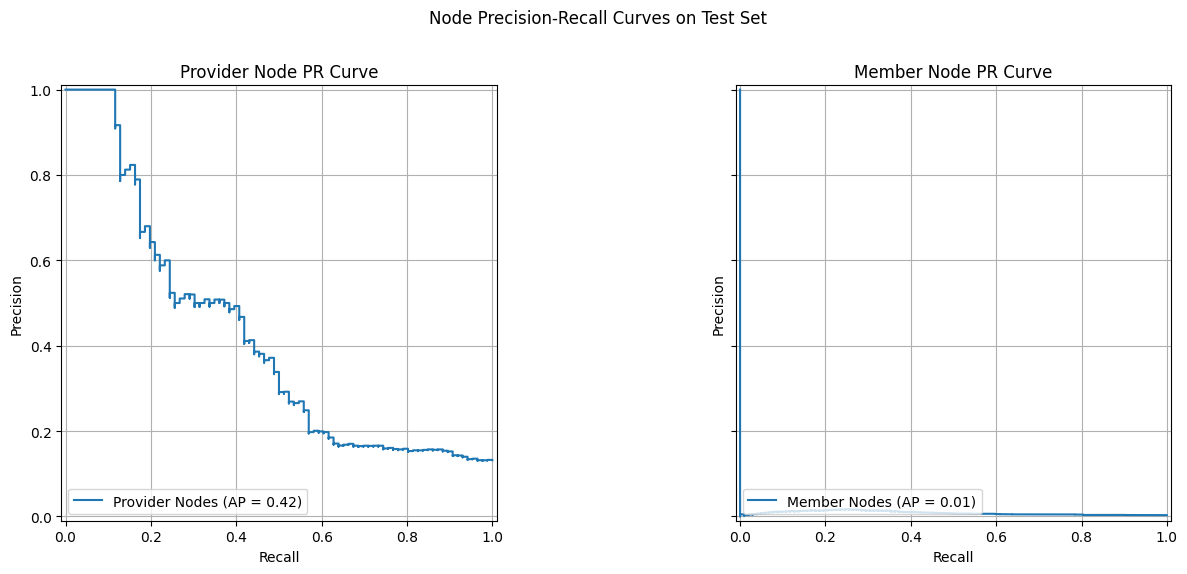


--- Plotting Edge Score Distribution (('provider', 'to', 'member')) ---


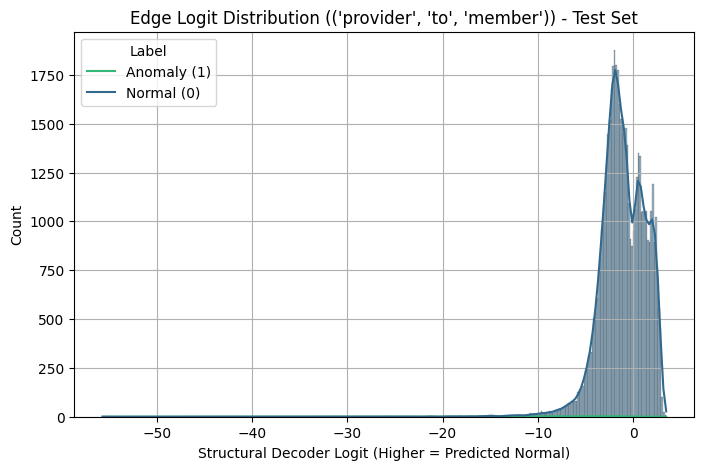

In [13]:
# %% [markdown]
# ## 5. Analyze and Visualize Results (Updated)

# %%
# --- Ensure these variables are defined from previous cells ---
# bgae_model (the trained model)
# train_data, val_data, test_data
# gt_node_labels (original node GT labels)
# gt_edge_labels (original edge GT labels, potentially stored in data splits as .y)
# train_lambda_attr, train_lambda_struct (used for training/scoring)
# ---

print("--- Running Final Evaluation with Updated Function ---")
k_values_for_eval = [50, 100, 200, 500] # K values for node P@K, R@K

# Evaluate on Validation Set
print("\n--- Evaluating on Validation Set ---")
val_node_results, val_edge_results, val_node_scores, val_edge_scores = evaluate_model_performance(
    model=bgae_model,
    eval_data=val_data, # Pass validation split
    train_data_struct=train_data,
    gt_node_labels=gt_node_labels_on_device, # Node labels
    lambda_attr=train_lambda_attr,
    lambda_struct=train_lambda_struct,
    target_edge_types_eval=[('provider', 'to', 'member'), ('member', 'to', 'provider')], # Evaluate both directions if available
    k_list=k_values_for_eval
)
print("\nValidation Node Results:")
val_node_results_df = pd.DataFrame(val_node_results).T
display(val_node_results_df)
print("\nValidation Edge Results:")
val_edge_results_df = pd.DataFrame(val_edge_results).T
display(val_edge_results_df)


# Evaluate on Test Set
print("\n--- Evaluating on Test Set ---")
test_node_results, test_edge_results, test_node_scores, test_edge_scores = evaluate_model_performance(
    model=bgae_model,
    eval_data=test_data, # Pass test split
    train_data_struct=train_data,
    gt_node_labels=gt_node_labels_on_device, # Node labels
    lambda_attr=train_lambda_attr,
    lambda_struct=train_lambda_struct,
    target_edge_types_eval=[('provider', 'to', 'member'), ('member', 'to', 'provider')], # Evaluate both directions
    k_list=k_values_for_eval
)
print("\nTest Node Results:")
test_node_results_df = pd.DataFrame(test_node_results).T
display(test_node_results_df)
print("\nTest Edge Results:")
test_edge_results_df = pd.DataFrame(test_edge_results).T
display(test_edge_results_df)


# --- Plotting (Example: Node PR Curves & Edge AUC/AP) ---
print("\n--- Plotting Evaluation Curves (Test Set) ---")
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Plot Node PR Curves (similar to before, using test_node_scores)
fig_pr_node, axes_pr_node = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
if 'provider' in test_node_results and 'provider' in test_node_scores:
    # Use node scores and gt_node_labels
    scores_p = test_node_scores['provider'].cpu().numpy()
    labels_p = gt_node_labels['provider'].cpu().numpy()
    if len(np.unique(labels_p)) > 1:
        precision, recall, _ = precision_recall_curve(labels_p, scores_p)
        ap_p = test_node_results['provider'].get('AP', 0)
        disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap_p)
        disp.plot(ax=axes_pr_node[0], name='Provider Nodes')
    axes_pr_node[0].set_title('Provider Node PR Curve')
    axes_pr_node[0].grid(True); axes_pr_node[0].set_ylim(bottom=0.0, top=1.05)

if 'member' in test_node_results and 'member' in test_node_scores:
    # Use node scores and gt_node_labels
    scores_m = test_node_scores['member'].cpu().numpy()
    labels_m = gt_node_labels['member'].cpu().numpy()
    if len(np.unique(labels_m)) > 1:
        precision, recall, _ = precision_recall_curve(labels_m, scores_m)
        ap_m = test_node_results['member'].get('AP', 0)
        disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap_m)
        disp.plot(ax=axes_pr_node[1], name='Member Nodes')
    axes_pr_node[1].set_title('Member Node PR Curve')
    axes_pr_node[1].grid(True)

plt.suptitle("Node Precision-Recall Curves on Test Set")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Plot Edge Score Distributions (Example for target_edge_type)
target_plot_edge_type = ('provider', 'to', 'member')
if target_plot_edge_type in test_edge_scores and hasattr(test_data[target_plot_edge_type], 'y'):
    print(f"\n--- Plotting Edge Score Distribution ({target_plot_edge_type}) ---")
    # Remember scores are logits (higher=normal), labels are 0/1 (1=anomaly)
    edge_scores_plot = test_edge_scores[target_plot_edge_type] # logits
    edge_labels_plot = test_data[target_plot_edge_type].y.cpu().numpy()

    df_edge = pd.DataFrame({'logit': edge_scores_plot, 'label': edge_labels_plot})
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df_edge, x='logit', hue='label', kde=True, palette='viridis')
    plt.title(f'Edge Logit Distribution ({target_plot_edge_type}) - Test Set')
    plt.xlabel('Structural Decoder Logit (Higher = Predicted Normal)')
    plt.legend(title='Label', labels=['Anomaly (1)', 'Normal (0)']) # Adjust labels if needed
    plt.grid(True)
    plt.show()

## 6. Analysis and Conclusion

Based on the results above, we can draw the following conclusions:

1. **Performance Comparison**: [Your analysis based on the results]
2. **Strengths and Weaknesses**: [Discuss strengths/weaknesses of different models]
3. **Recommended Model**: [Which model performed best and why]
4. **Future Work**: [Suggestions for improvements]

In [15]:
# %% [markdown]
# ## 6. Baseline Model Comparison
#
# Evaluate simpler, non-graph baseline models (Isolation Forest and One-Class SVM)
# on the node features for comparison.

# %%
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
# Make sure SklearnBaseline is imported from your baseline_models file
# from src.models.baseline_models import SklearnBaseline
# Make sure compute_evaluation_metrics is imported
# from src.utils.eval_utils import compute_evaluation_metrics

# --- Configuration ---
# Use the data *with* anomalies injected, but *before* edge splitting,
# as these models only care about node features.
# Ensure data and labels are on CPU for sklearn models.
data_for_baselines = anomaly_data.cpu() # Use the graph data with anomalies injected
gt_node_labels_cpu = {k: v.cpu() for k, v in gt_node_labels.items()}

# Evaluation parameters (same as BGAE eval)
k_values_for_eval = [50, 100, 200, 500]

baseline_configs = {
    'Isolation Forest': {'method': 'iforest', 'random_state': 42, 'n_estimators': 100, 'contamination': 'auto'},
    'One-Class SVM': {'method': 'ocsvm', 'nu': 0.1, 'kernel': 'rbf', 'gamma': 'auto'} # Adjust nu/gamma as needed
    # Add PCA baseline if desired:
    # 'PCA Anomaly': {'method': 'pca', 'n_components': 0.95}
}

all_baseline_results = {}

# --- Run Baselines ---
print("--- Evaluating Baseline Models ---")

for name, config in baseline_configs.items():
    print(f"\n--- Running {name} ---")
    method = config.pop('method') # Extract method name
    try:
        baseline_model = SklearnBaseline(method=method, **config)

        # Fit the model on the node features
        # SklearnBaseline's fit handles extracting .x from the data object
        print(f"Fitting {name}...")
        baseline_model.fit(data_for_baselines)

        # Compute anomaly scores (higher score = more anomalous)
        print(f"Computing anomaly scores for {name}...")
        baseline_scores = baseline_model.compute_anomaly_scores(data_for_baselines)

        # Evaluate scores
        print(f"Evaluating {name}...")
        results_for_baseline = {}
        for node_type in ['provider', 'member']:
            if node_type in baseline_scores and node_type in gt_node_labels_cpu:
                scores_np = baseline_scores[node_type].numpy() # Scores are already on CPU
                labels_np = gt_node_labels_cpu[node_type].numpy()

                if len(np.unique(labels_np)) < 2:
                    print(f"Warning: Only one class present for {node_type} labels. Skipping metrics.")
                    results_for_baseline[node_type] = {}
                    continue
                if len(scores_np) != len(labels_np):
                    print(f"Error: Score length ({len(scores_np)}) mismatch with label length ({len(labels_np)}) for {node_type}. Skipping.")
                    results_for_baseline[node_type] = {}
                    continue

                # Compute metrics using the existing function
                metrics = compute_evaluation_metrics(scores_np, labels_np, k_list=k_values_for_eval)
                results_for_baseline[node_type] = metrics
                print(f"  {node_type.capitalize()} Results ({name}): { {k: f'{v:.4f}' for k,v in metrics.items() if k in ['AUROC', 'AP', 'Best F1']} }") # Print summary
            else:
                results_for_baseline[node_type] = {}

        all_baseline_results[name] = results_for_baseline

    except Exception as e:
        print(f"Error running baseline {name}: {e}")
    finally:
        # Add method back if needed elsewhere, or handle config immutably
        config['method'] = method

# --- Display Baseline Results ---
print("\n--- Combined Baseline Results ---")
# Combine results into DataFrames for easier viewing
baseline_provider_results = {name: res.get('provider', {}) for name, res in all_baseline_results.items()}
baseline_member_results = {name: res.get('member', {}) for name, res in all_baseline_results.items()}

df_baseline_provider = pd.DataFrame(baseline_provider_results).T
df_baseline_member = pd.DataFrame(baseline_member_results).T

print("\nProvider Node Baseline Performance:")
display(df_baseline_provider)
print("\nMember Node Baseline Performance:")
display(df_baseline_member)

# Store baseline results alongside BGAE results for comparison table generation
# Example: You might want to combine test_node_results_df with these dfs
# For now, they are separate.

--- Evaluating Baseline Models ---

--- Running Isolation Forest ---
Fitting Isolation Forest...
Computing anomaly scores for Isolation Forest...
Evaluating Isolation Forest...
  Provider Results (Isolation Forest): {'AUROC': '0.6711', 'AP': '0.3533', 'Best F1': '0.3871'}
  Member Results (Isolation Forest): {'AUROC': '0.6941', 'AP': '0.0147', 'Best F1': '0.0608'}

--- Running One-Class SVM ---
Fitting One-Class SVM...
Computing anomaly scores for One-Class SVM...
Evaluating One-Class SVM...
  Provider Results (One-Class SVM): {'AUROC': '0.6805', 'AP': '0.3585', 'Best F1': '0.3846'}
  Member Results (One-Class SVM): {'AUROC': '0.6966', 'AP': '0.0152', 'Best F1': '0.0696'}

--- Combined Baseline Results ---

Provider Node Baseline Performance:


,AUROC,AP,Precision@50,Recall@50,Precision@100,Recall@100,Precision@200,Recall@200,Precision@500,Recall@500,Best F1,Best F1 Threshold
Isolation Forest,0.67109,0.353349,0.48,0.279070,0.36,0.418605,0.240,0.558140,0.144,0.837209,0.387097,-0.031389
One-Class SVM,0.68050,0.358533,0.46,0.267442,0.30,0.348837,0.225,0.523256,0.152,0.883721,0.384615,-0.000227



Member Node Baseline Performance:


,AUROC,AP,Precision@50,Recall@50,Precision@100,Recall@100,Precision@200,Recall@200,Precision@500,Recall@500,Best F1,Best F1 Threshold
Isolation Forest,0.694087,0.014706,0.02,0.009804,0.05,0.04902,0.045,0.088235,0.030,0.147059,0.060811,0.123723
One-Class SVM,0.696633,0.015167,0.02,0.009804,0.05,0.04902,0.050,0.098039,0.028,0.137255,0.069620,208.864975


In [17]:
# %% [markdown]
# ## Utilities

# %%
import pandas as pd

def format_results_to_latex(results_df, caption="Performance Metrics", label="tab:results",
                            columns=None, float_format="%.4f", add_midrule=True):
    """
    Converts a pandas DataFrame containing evaluation results into a LaTeX table string.

    Args:
        results_df (pd.DataFrame): DataFrame with metrics (rows=models/node_types, cols=metrics).
        caption (str): Caption for the LaTeX table.
        label (str): LaTeX label for cross-referencing.
        columns (list, optional): Subset of columns to include. Defaults to all.
        float_format (str): Format string for floating-point numbers.
        add_midrule (bool): Whether to add \midrule after the header.

    Returns:
        str: A string containing the LaTeX table code.
    """
    if results_df.empty:
        return f"% DataFrame is empty, cannot generate table for {label}\n"

    # Select columns if specified
    if columns:
        results_df = results_df[[col for col in columns if col in results_df.columns]]

    # Use to_latex function
    latex_string = results_df.to_latex(
        float_format=float_format,
        caption=caption,
        label=label,
        index=True, # Assuming index is meaningful (e.g., model name or node type)
        header=True,
        escape=False, # Assume no special LaTeX characters need escaping in headers/index
        column_format='l' + 'c' * len(results_df.columns) # l for index, c for metrics
    )

    # Optional: Add \midrule for better table structure in booktabs style
    if add_midrule:
        lines = latex_string.splitlines()
        header_end_index = -1
        for i, line in enumerate(lines):
            if '\\toprule' in line:
                header_end_index = i + 1 # Header line is usually after toprule
                break
        if header_end_index != -1 and header_end_index < len(lines) - 1:
             # Insert \midrule after the header line
             lines.insert(header_end_index + 1, '\\midrule')
             latex_string = '\n'.join(lines)


    # Optional: Add resizebox wrapper if table is too wide
    # Note: Requires \usepackage{graphicx} in LaTeX preamble
    resize_wrapper = True # Set to False if you don't want resizebox
    if resize_wrapper:
        latex_string = latex_string.replace('\\begin{tabular}', '\\resizebox{\\linewidth}{!}{\\begin{tabular}')
        latex_string = latex_string.replace('\\end{tabular}', '\\end{tabular}}')


    return latex_string